# Load up required libraries and dataset

In [1]:
#Standard Math / Data Packages
import pandas as pd
import numpy as np

#Plotting Packages
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Data Splitting, Scaling and Cross Validation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from keras_tuner.tuners import RandomSearch
from bayes_opt import BayesianOptimization

#ML Models
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#Metrics and Scoring
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

#to ignore warnings
import warnings
warnings.filterwarnings('ignore')
pd.set_option('future.no_silent_downcasting', True)

In [2]:
#Implementing metric functions
import numpy as np; from sklearn.metrics import mean_squared_error

# NASH-Sutcliffe Model Efficiency Coefficent
def calc_nse(observed, simulated): 
    return 1 - np.sum((observed-simulated)**2) / np.sum((observed-np.mean(observed))**2)

#Root-Mean-Square Deviation
def calc_rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

In [3]:
sns.set_style('darkgrid')
plt.rcParams['font.family'] = 'Times New Roman'

In [4]:
data_dir = 'data/'  
data_file = data_dir + 'Australian Vehicle Prices.csv'

data = pd.read_csv(data_file)

data.head()

Brand    Year   Model               Car/Suv  \
0      Ssangyong  2022.0  Rexton  Sutherland Isuzu Ute   
1             MG  2022.0     MG3             Hatchback   
2            BMW  2022.0    430I                 Coupe   
3  Mercedes-Benz  2011.0    E500                 Coupe   
4        Renault  2022.0  Arkana                   SUV   

                                       Title UsedOrNew Transmission  \
0       2022 Ssangyong Rexton Ultimate (awd)      DEMO    Automatic   
1  2022 MG MG3 Auto Excite (with Navigation)      USED    Automatic   
2                      2022 BMW 430I M Sport      USED    Automatic   
3           2011 Mercedes-Benz E500 Elegance      USED    Automatic   
4                 2022 Renault Arkana Intens      USED    Automatic   

         Engine DriveType  FuelType FuelConsumption Kilometres   ColourExtInt  \
0  4 cyl, 2.2 L       AWD    Diesel  8.7 L / 100 km       5595  White / Black   
1  4 cyl, 1.5 L     Front   Premium  6.7 L / 100 km         16  Black / Black   
2    4 cyl, 2 L      Rear   Premium  6.6 L / 100 km       8472   Grey / White   
3  8 cyl, 5.5 L      Rear   Premium   11 L / 100 km     136517  White / Brown   
4  4 cyl, 1.3 L     Front  Unleaded    6 L / 100 km       1035   Grey / Black   

            Location CylindersinEngine   BodyType     Doors     Seats   Price  
0     Caringbah, NSW             4 cyl        SUV   4 Doors   7 Seats   51990  
1     Brookvale, NSW             4 cyl  Hatchback   5 Doors   5 Seats   19990  
2      Sylvania, NSW             4 cyl      Coupe   2 Doors   4 Seats  108988  
3  Mount Druitt, NSW             8 cyl      Coupe   2 Doors   4 Seats   32990  
4   Castle Hill, NSW             4 cyl        SUV   4 Doors   5 Seats   34990

# Data Cleaning & Preparation

In [5]:
#Drop missing values
data = data.dropna()

#Drop engine capacities that are equal to 0 liters
data = data.loc[data['Engine']!='0 L']

#Extract number of cylinders from string
data['CylindersinEngine'] = data['CylindersinEngine'].str.extract('(\d+)').astype('int')
data.rename(columns={'CylindersinEngine': 'Cylinders'}, inplace=True)

#Drop price on applications
data = data.loc[data['Price']!='POA']

#Convert string to int
data['Year'] = data['Year'].astype('int')
data['Price'] = data['Price'].astype('int')
data.loc[data['Kilometres']=='-', 'Kilometres'] = 0 #Replace "-" values with 0
data['Kilometres'] = data['Kilometres'].astype('int')

#Extract engine capacity in liters from string
data[['_','Engine']] = data['Engine'].str.split(', ', expand=True)
data.drop(columns=['_'], inplace=True)
data.rename(columns={'Engine': 'EngineCapacity'}, inplace=True)
data['EngineCapacity'] = data['EngineCapacity'].str.extract(r'([-+]?\d*\.?\d+)').astype('float')

#Car condition can be either new or used
data = data.loc[data['UsedOrNew']!='DEMO']
data.rename(columns={'UsedOrNew': 'Condition'}, inplace=True)

#Transmissions can be either automatic or manual
data = data.loc[data['Transmission']!='-']

#Drop fuel types that are nan
data = data.loc[data['FuelType']!='-']

#Correcting "Ute / Tray" for better readability
data['BodyType'].replace('Ute / Tray','Ute Tray',inplace=True)

#A car cannot be 0 Kilometers and "USED" at the same time
data = data.loc[~((data['Kilometres']==0) & (data['Condition']=='USED'))]
data.rename(columns={'Kilometres': 'Mileage'}, inplace=True)

#Drop brands with less than 100 cars
brand_counts = data.groupby('Brand')['Brand'].agg('count')
brand_counts_below100 = brand_counts.loc[brand_counts<100]
brands_below100 = brand_counts_below100.index
data = data.loc[~data['Brand'].isin(brands_below100)]

data.drop(columns=['Model'], inplace=True)  #Depends on the brand
data.drop(columns=['Title'], inplace=True)  #Already available in both the brand and year columns
data.drop(columns=['Car/Suv'], inplace=True)  #Exactly the same as the "BodyType" column
data.drop(columns=['ColourExtInt'], inplace=True)  #Doesn't have any useful information
data.drop(columns=['Location'], inplace=True)  #Doesn't have any useful information
data.drop(columns=['Doors'], inplace=True)  #Depends on the body type
data.drop(columns=['Seats'], inplace=True)  #Depends on the body type
data.drop(columns=['FuelConsumption'], inplace=True)  #Depends on engine capacity

data.drop_duplicates(inplace=True)
data.reset_index(drop=True, inplace=True)
data.head()

Brand  Year Condition Transmission  EngineCapacity DriveType  \
0             MG  2022      USED    Automatic             1.5     Front   
1            BMW  2022      USED    Automatic             2.0      Rear   
2  Mercedes-Benz  2011      USED    Automatic             5.5      Rear   
3        Renault  2022      USED    Automatic             1.3     Front   
4           Land  2017      USED    Automatic             2.0       AWD   

   FuelType  Mileage  Cylinders   BodyType   Price  
0   Premium       16          4  Hatchback   19990  
1   Premium     8472          4      Coupe  108988  
2   Premium   136517          8      Coupe   32990  
3  Unleaded     1035          4        SUV   34990  
4    Diesel    67662          4        SUV   62280

In [6]:
summary = data.describe().loc[['min','25%','50%','mean','75%','max']]
summary = summary.reset_index(drop=True)
summary[''] = ['Min','1st Qu.','Median','Mean','3rd Qu.','Max']
summary.set_index('', inplace=True);summary.round(2)

Year  EngineCapacity    Mileage  Cylinders      Price
                                                                 
Min      1984.00            1.00       0.00       2.00    1200.00
1st Qu.  2013.00            2.00   47909.50       4.00   17999.00
Median   2017.00            2.20   89992.50       4.00   27990.00
Mean     2015.93            2.41  105539.23       4.43   32683.91
3rd Qu.  2019.00            2.80  152094.75       4.00   39990.00
Max      2023.00            7.30  526162.00      12.00  436900.00

&nbsp;

# Exploratory Data Analysis

### Univariate analysis before removing outliers

Year
Skew : -1.07


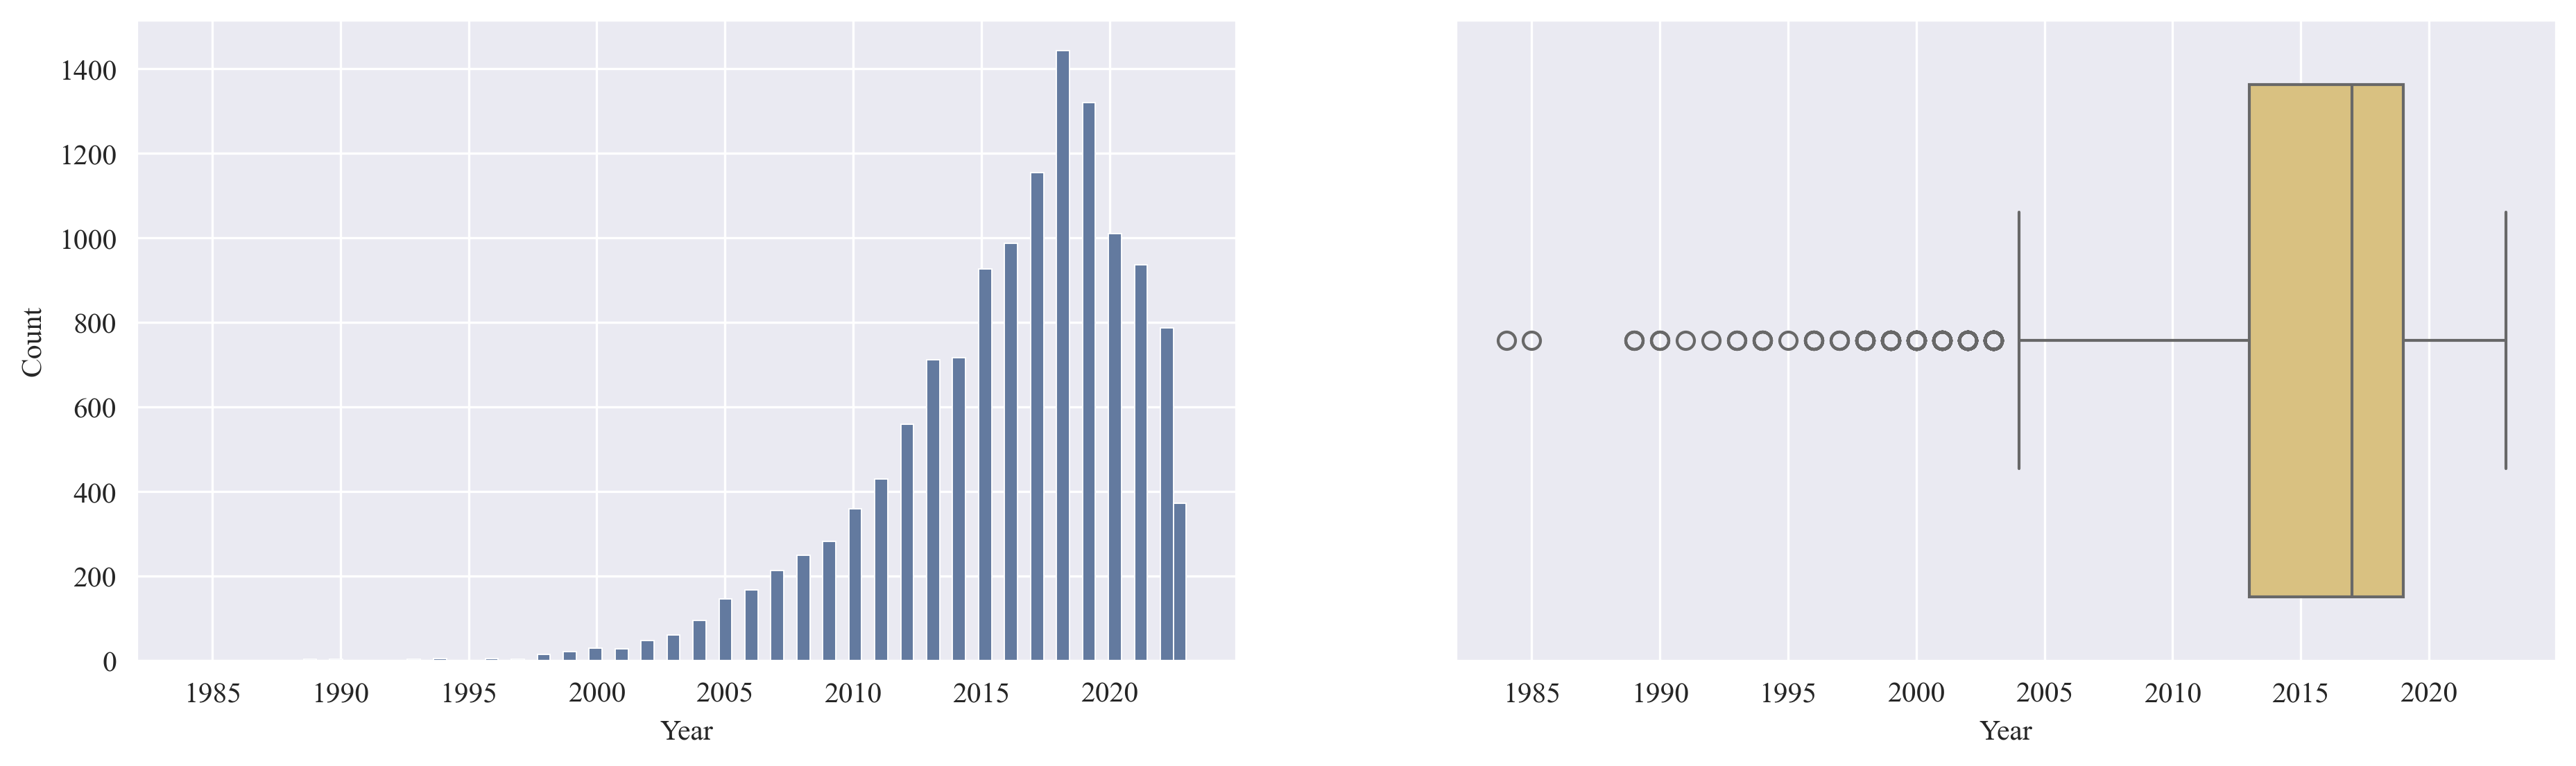

EngineCapacity
Skew : 1.48


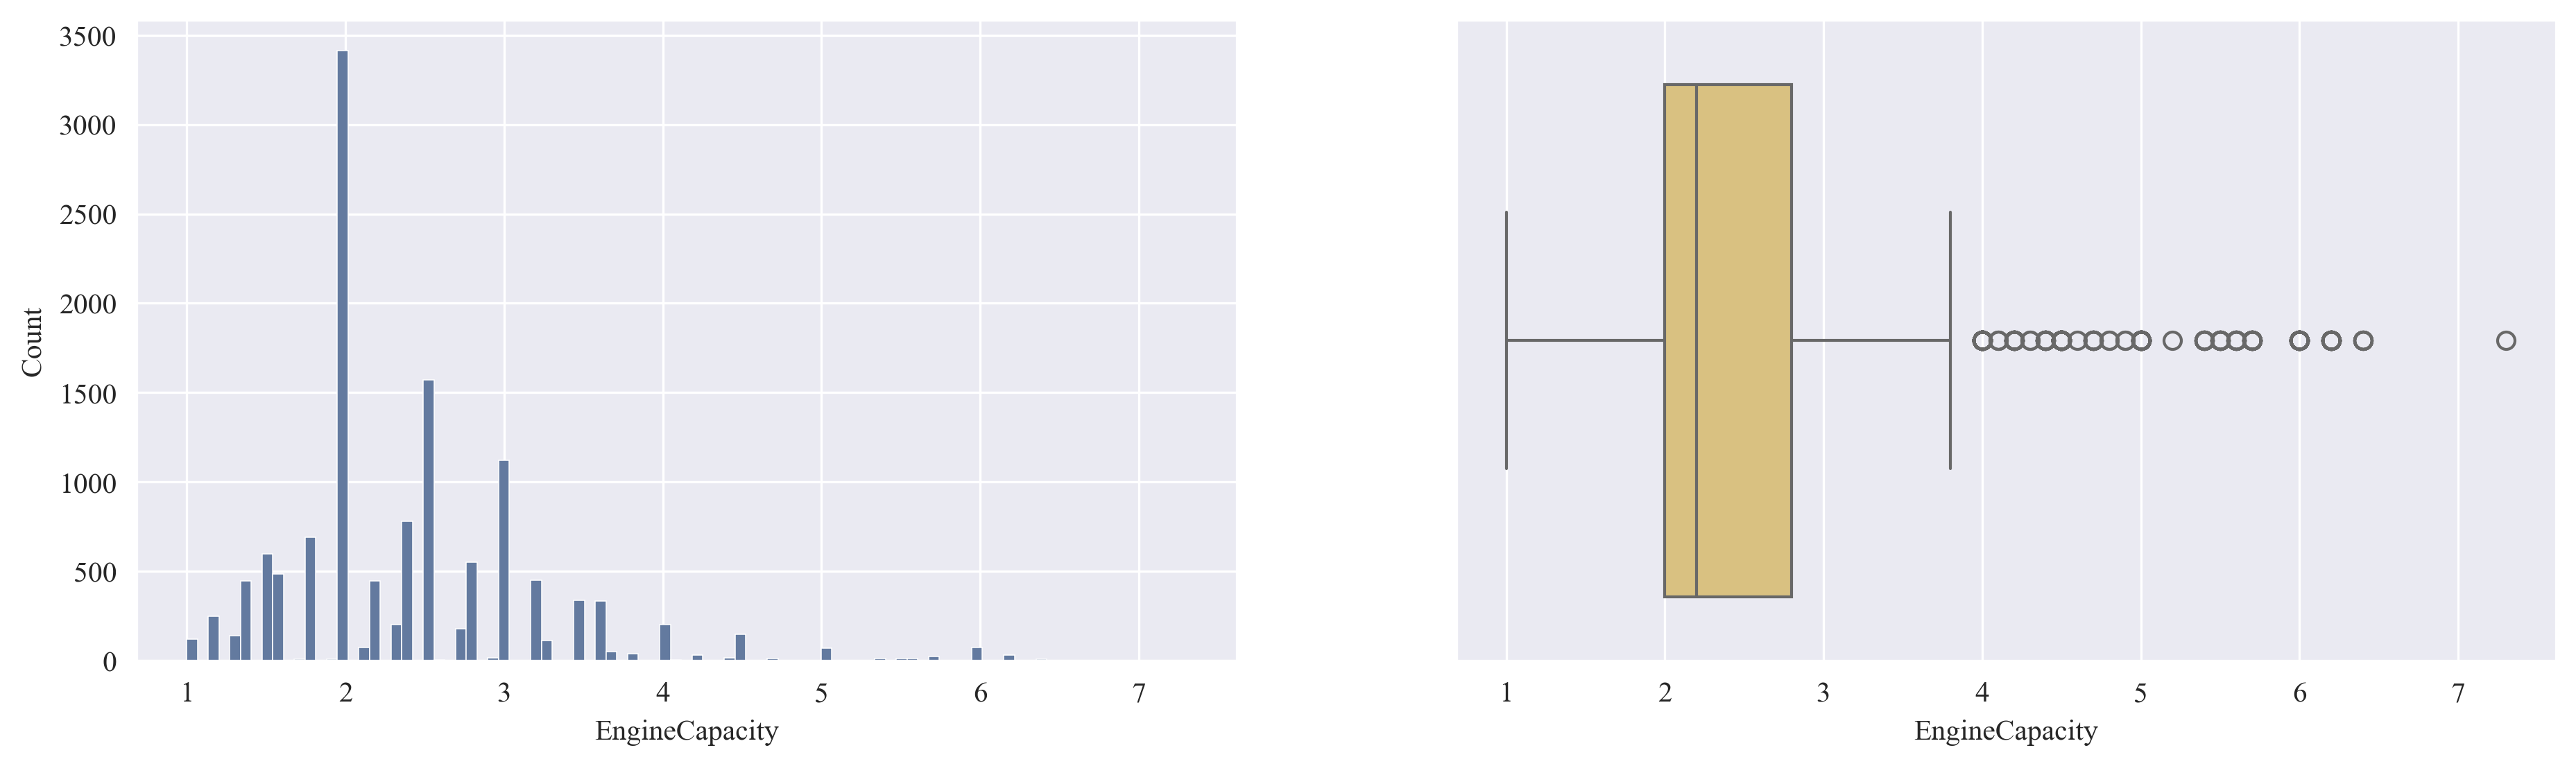

Mileage
Skew : 0.98


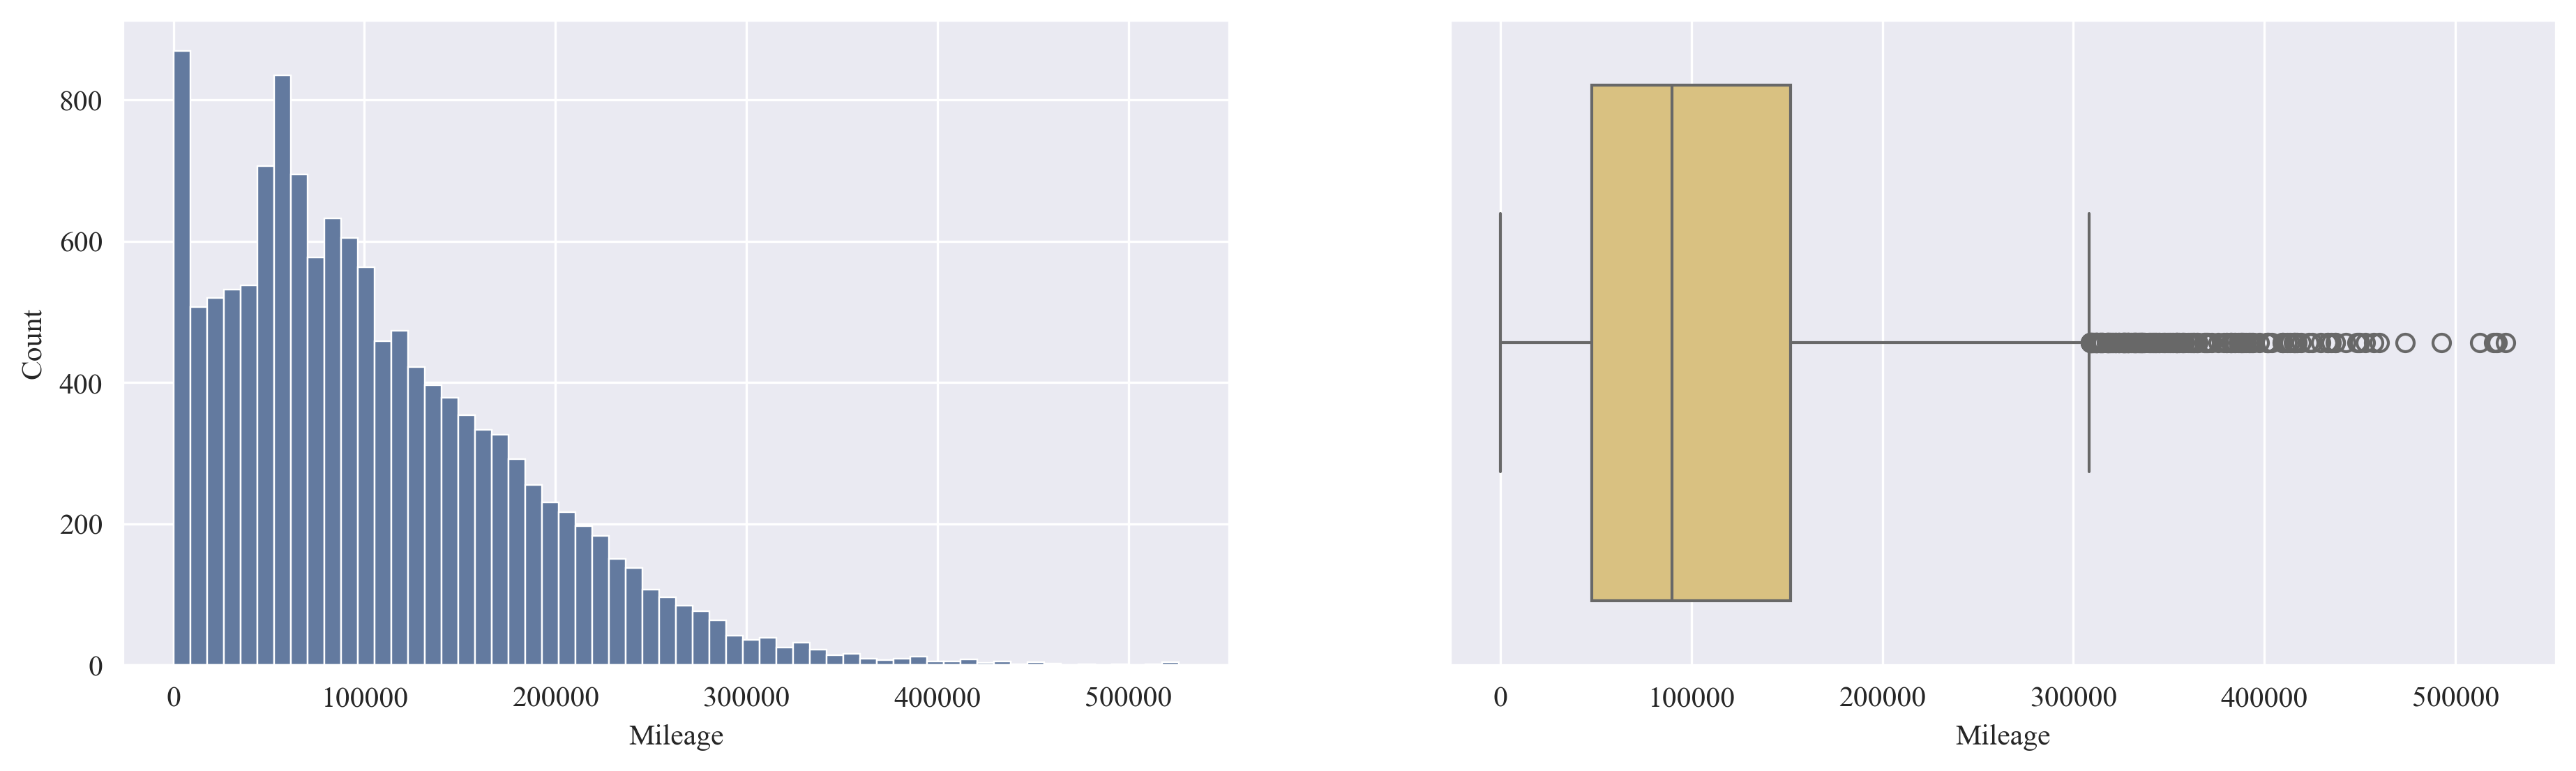

Price
Skew : 3.53


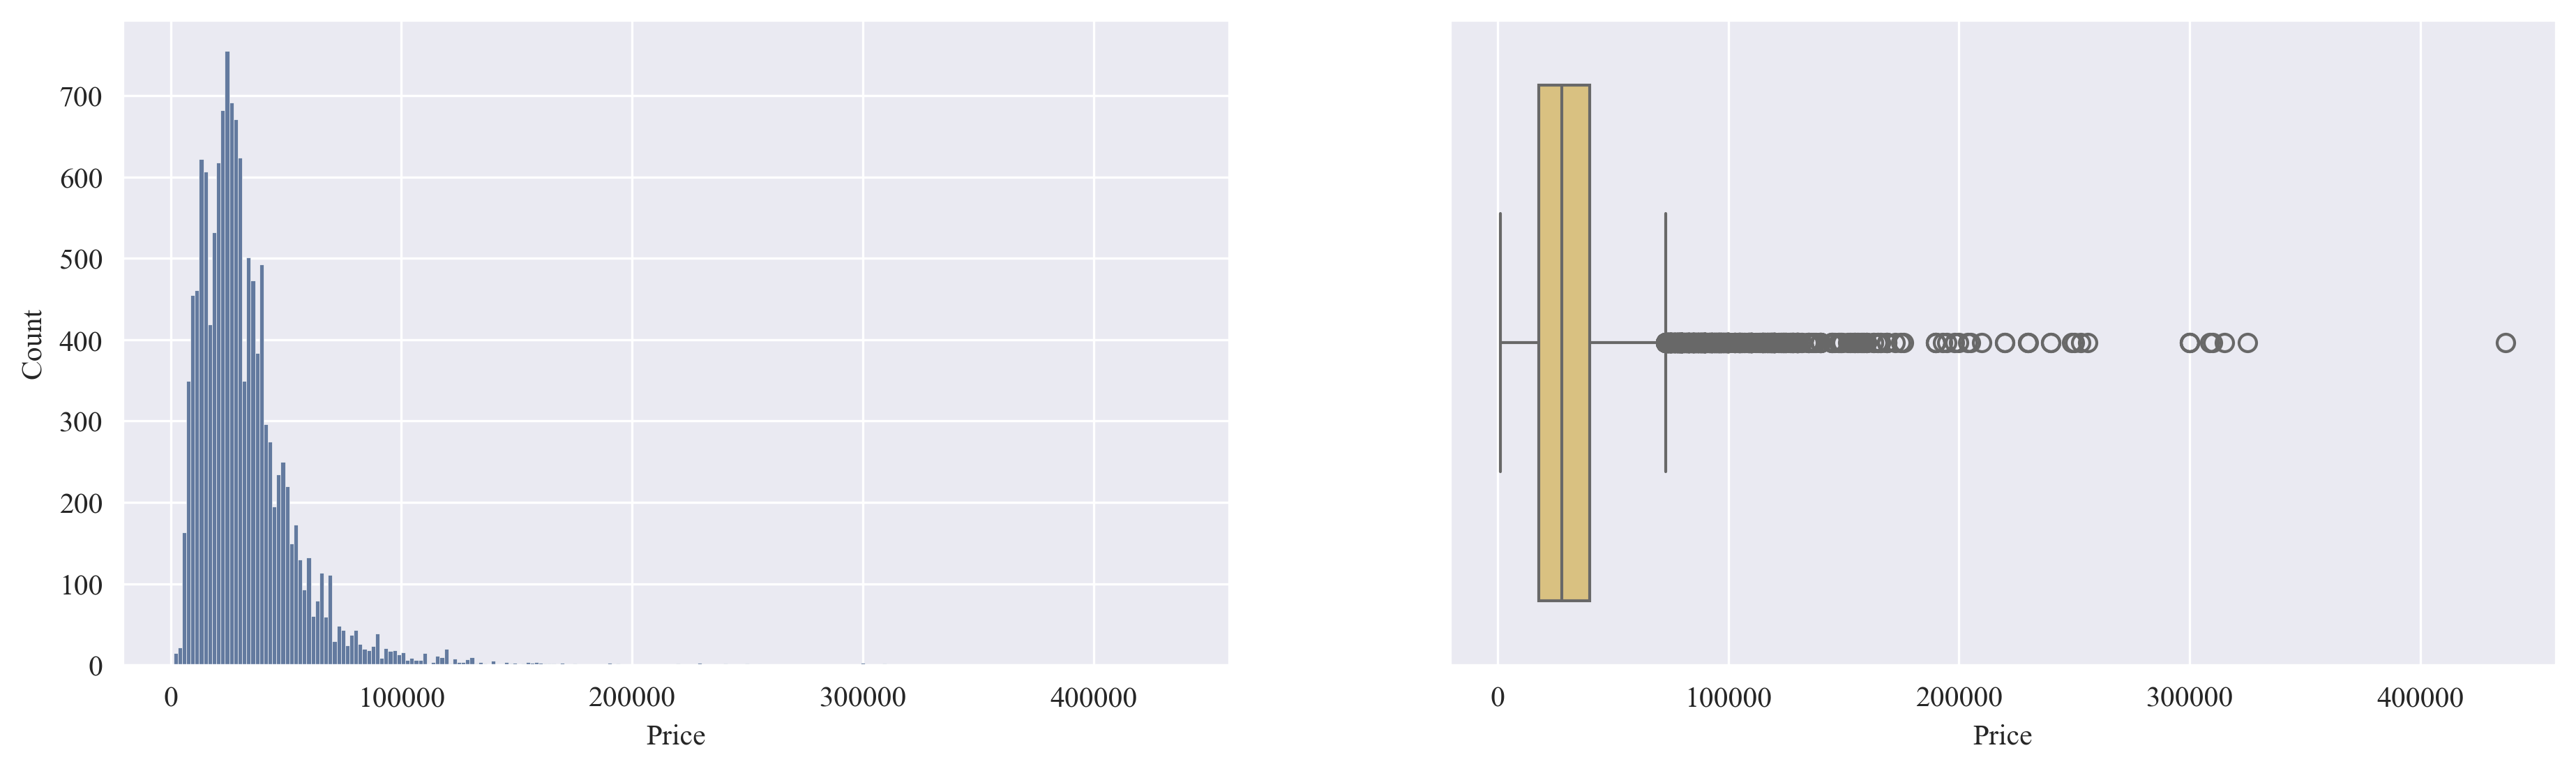

In [7]:
for col in ['Year','EngineCapacity','Mileage','Price']:
    print(col)
    print('Skew :', round(data[col].skew(), 2))
    plt.figure(figsize = (15, 4), dpi=300)
    plt.subplot(1, 2, 1)
    sns.histplot(data[col], color='#637A9F', alpha=1)
    plt.ylabel('Count')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=data[col], color='#E8C872')
    plt.show()

### Univariate analysis after removing outliers

In [7]:
def remove_outliers(data, features):
    for feature in features:
        q1 = np.quantile(data[feature], 0.25)
        q3 = np.quantile(data[feature], 0.75)
        iqr = q3 - q1
        
        upperlimit = q3 + 1.5*iqr
        lowerlimit = q1 - 1.5*iqr
    
        data = data.loc[(data[feature]>lowerlimit) & (data[feature]<upperlimit)]
    return data

In [8]:
data = remove_outliers(data, ['Mileage','Price','EngineCapacity','Year'])

Year
Skew : -0.51


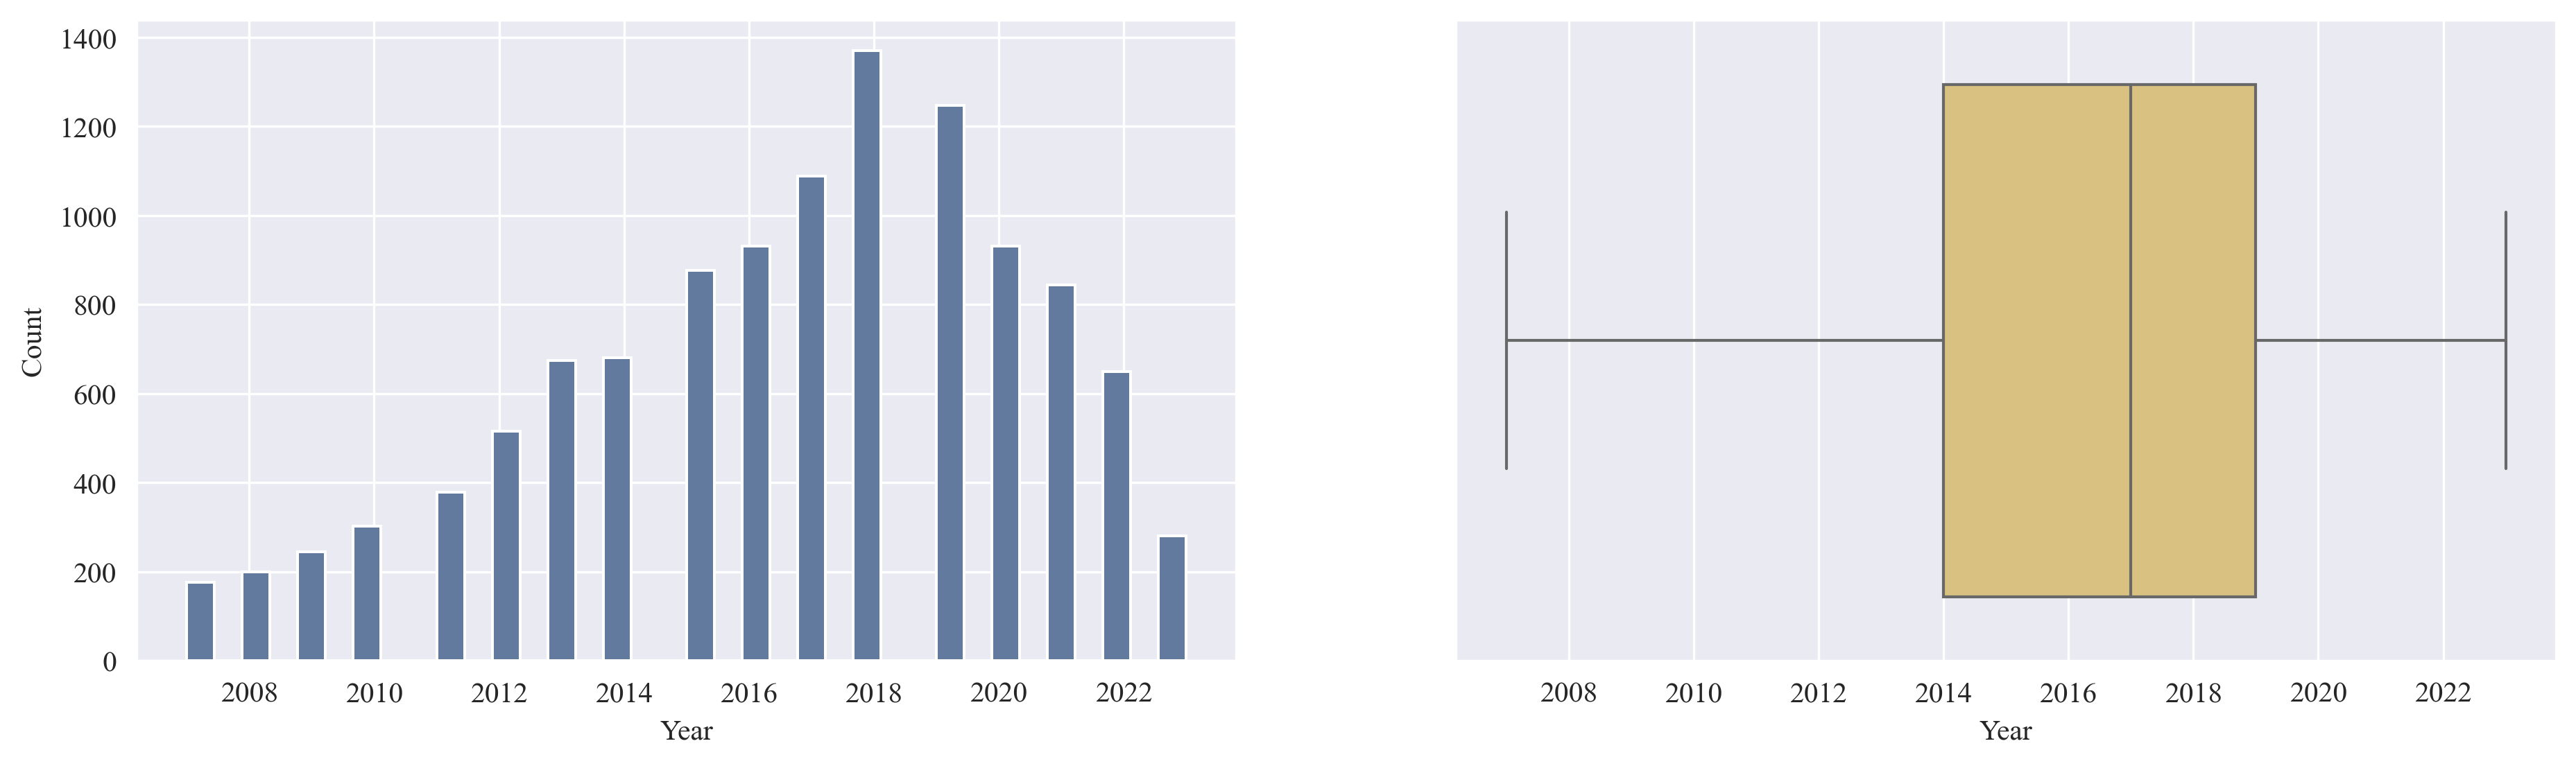

EngineCapacity
Skew : 0.41


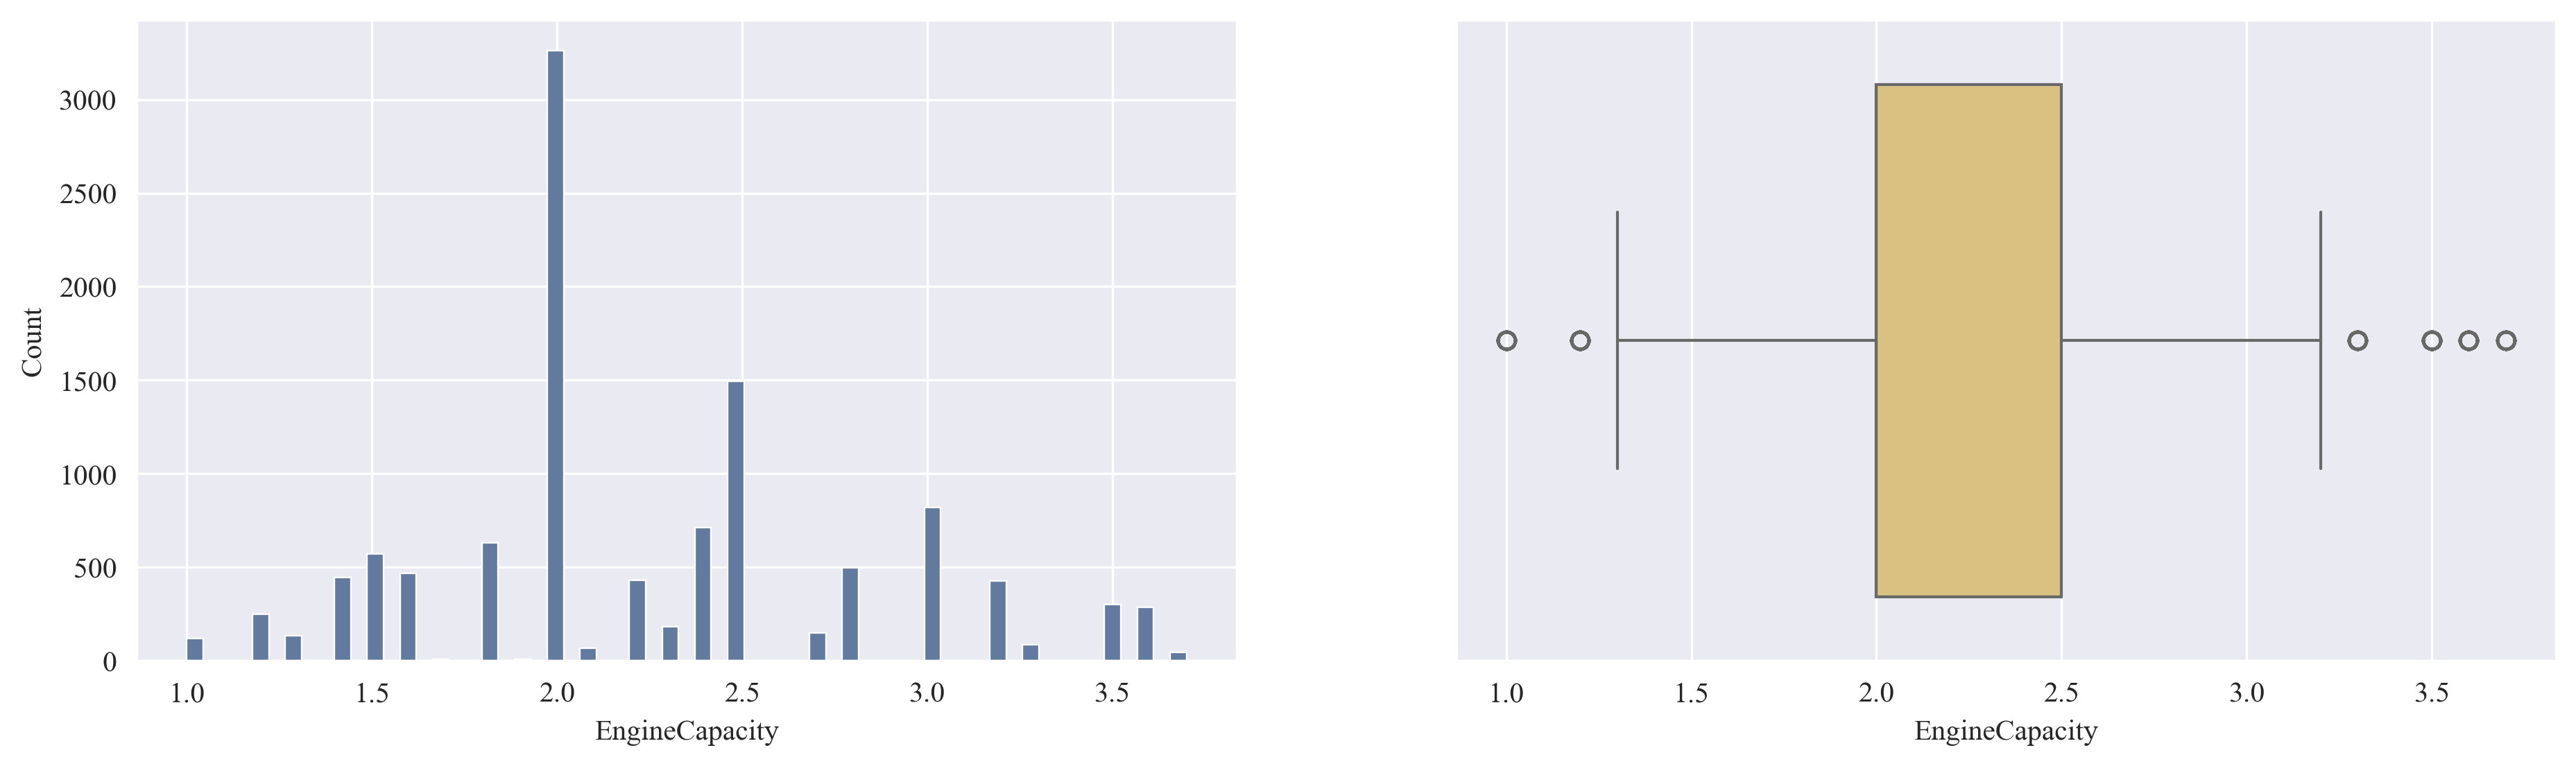

Mileage
Skew : 0.68


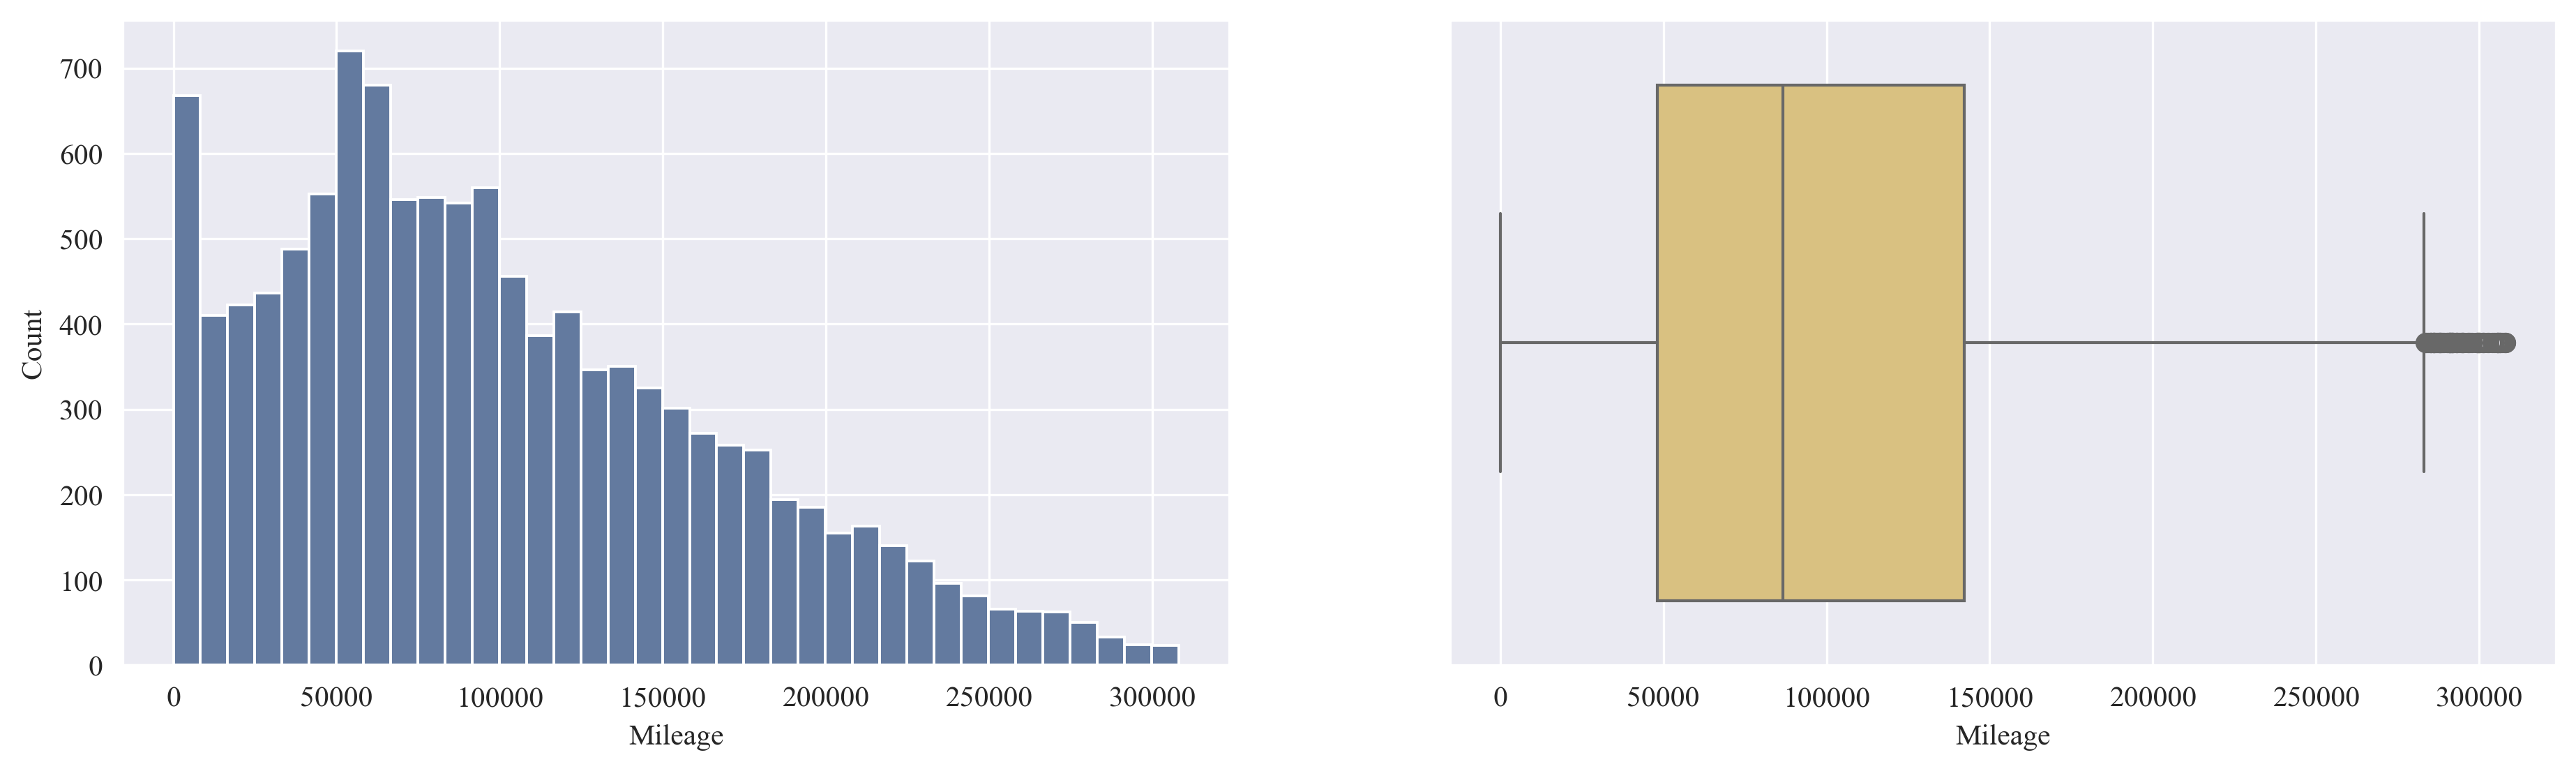

Price
Skew : 0.67


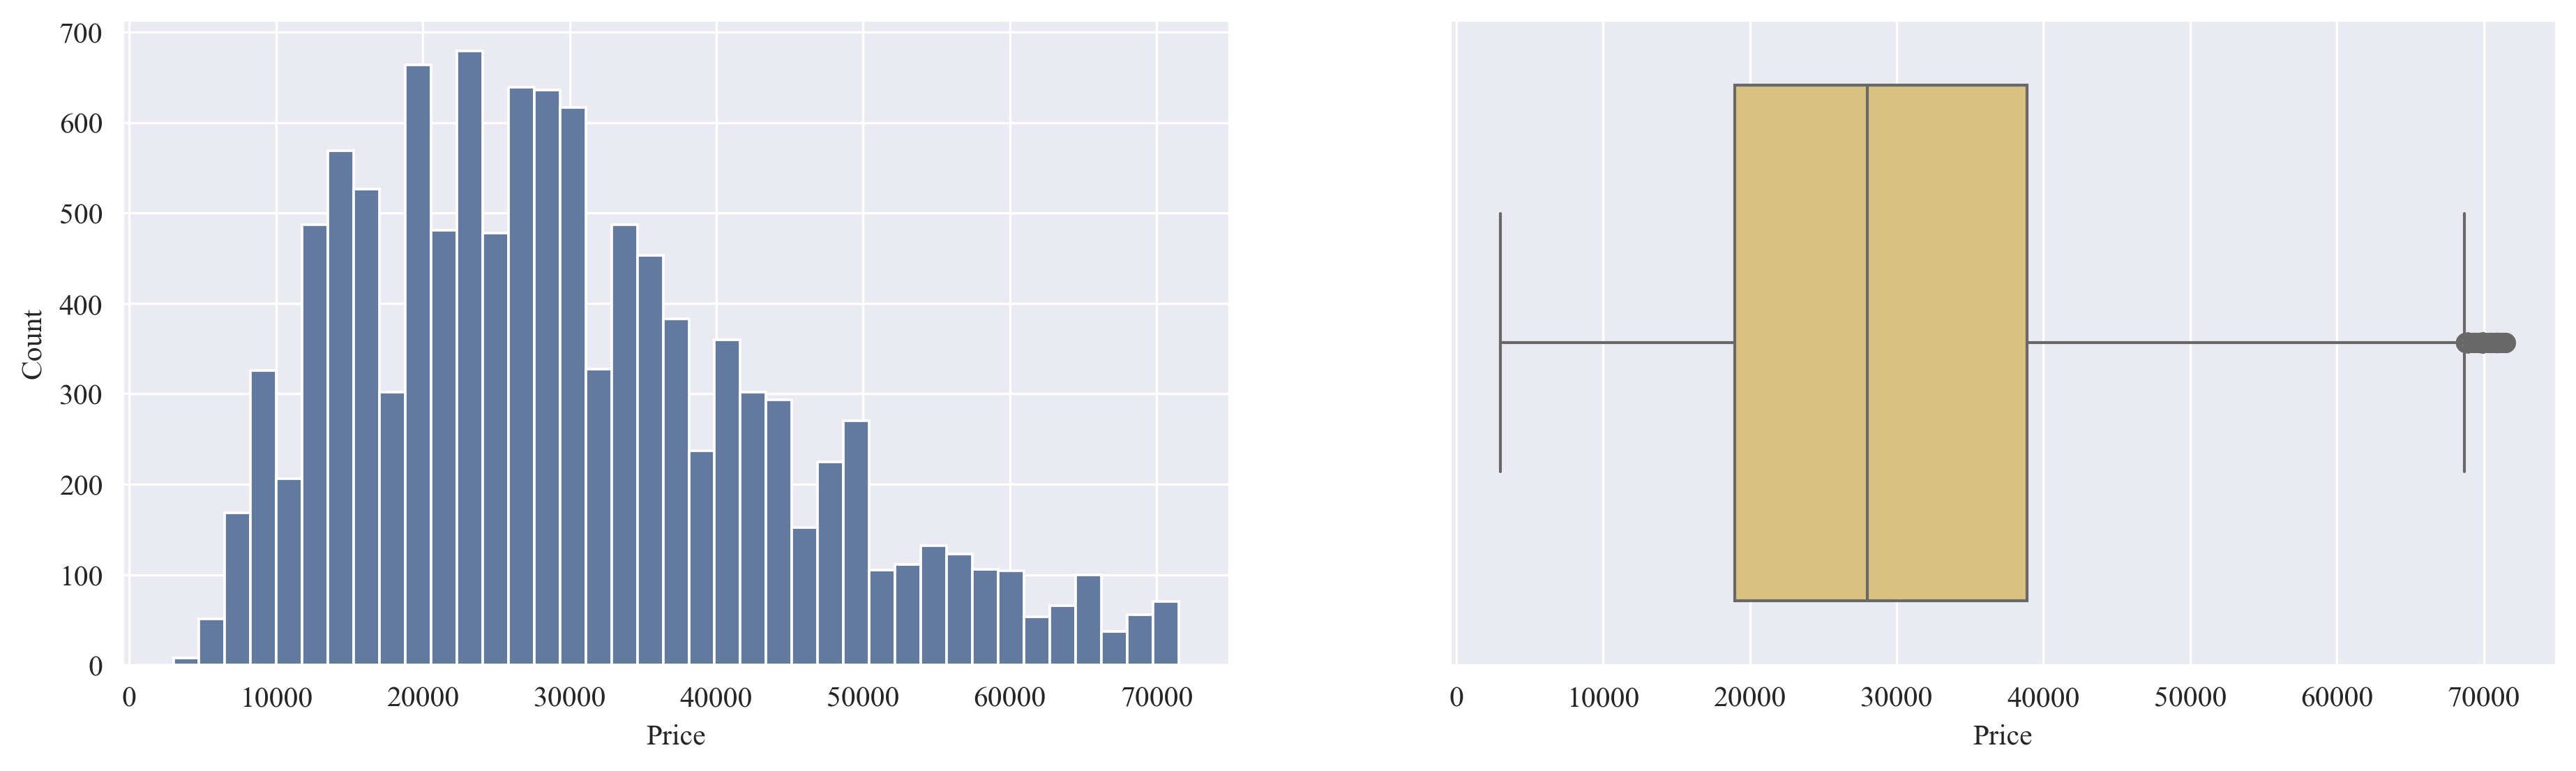

In [10]:
for col in ['Year','EngineCapacity','Mileage','Price']:
    print(col)
    print('Skew :', round(data[col].skew(), 2))
    plt.figure(figsize = (15, 4), dpi=300)
    plt.subplot(1, 2, 1)
    sns.histplot(data[col], color='#637A9F', alpha=1)
    plt.ylabel('Count')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=data[col], color='#E8C872')
    plt.show()

### Bivariate analysis

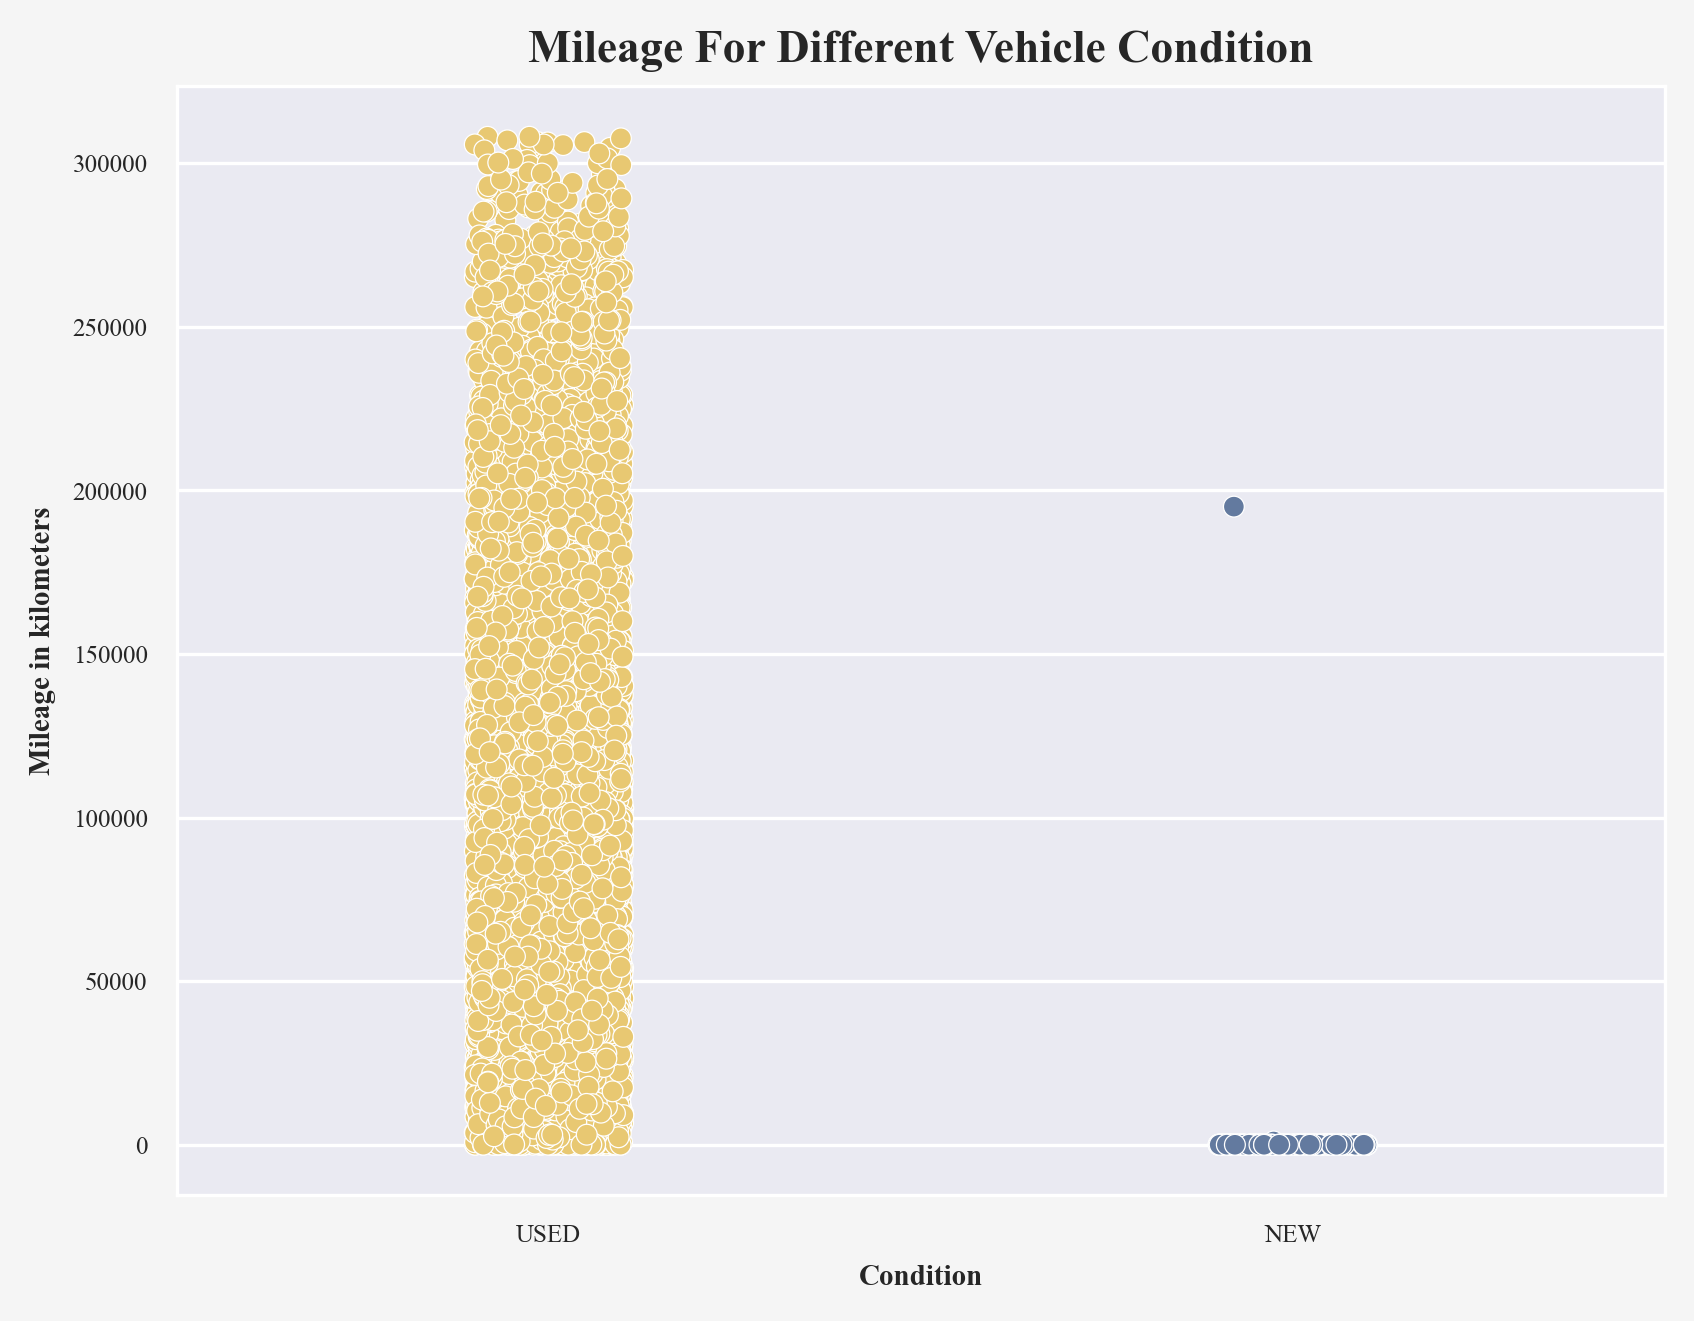

In [11]:
plt.figure(facecolor='whitesmoke', dpi=300)
plt.title('Mileage for different vehicle condition'.title(), fontweight='bold', fontsize=11)
sns.stripplot(data=data, x='Condition', y='Mileage',
              color='#637A9F', edgecolor='white', linewidth=.3,hue='Condition',palette=['#E8C872','#637A9F'])
plt.ylabel('Mileage in kilometers', fontweight='bold', fontsize=7)
plt.xlabel('Condition', fontweight='bold', fontsize=7)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6);

These cases need to be filtered out:
- There is a car that has close to 200,000 kilometers and yet has been classified as NEW.
- There are also cars that have less than 50 kilometers and are recognized as USED.

In [9]:
data = data.loc[~((data['Condition']=='NEW') & (data['Mileage']>1000))]
data = data.loc[~((data['Condition']=='USED') & (data['Mileage']<50))]

<Figure size 1920x1440 with 0 Axes>

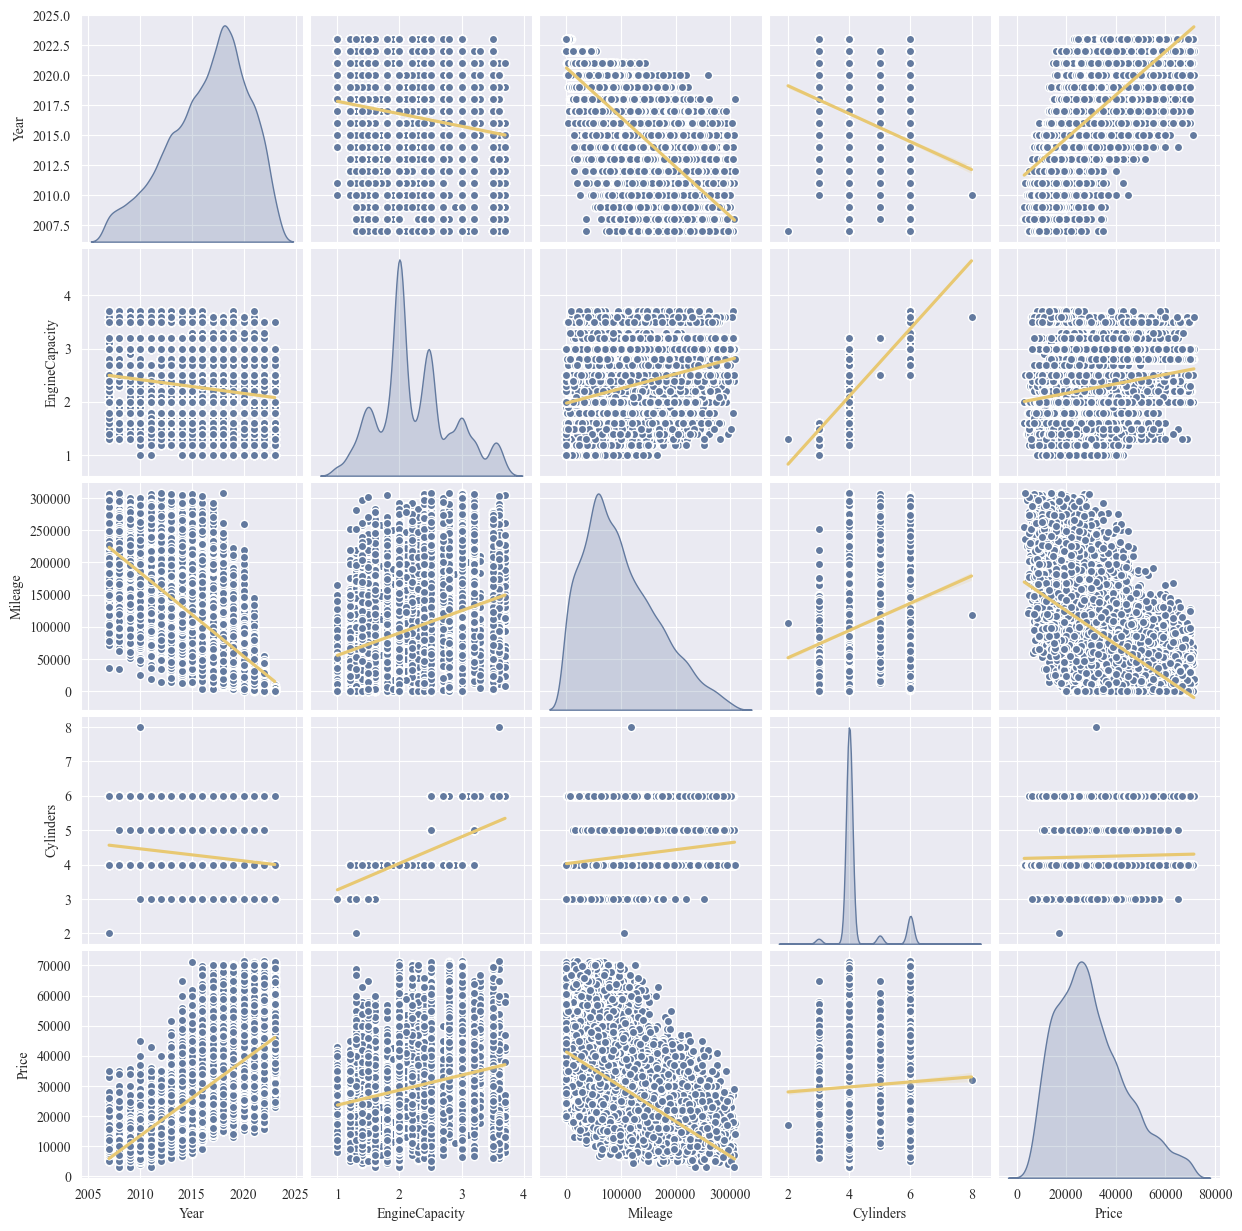

In [13]:
plt.figure(facecolor='whitesmoke', dpi=300)
sns.pairplot(data, kind='reg', plot_kws={'line_kws':{'color':'#E8C872'},
                                         'scatter_kws':{'edgecolor':'white','alpha':1},
                                         'color':'#637A9F'},
             diag_kws={'color':'#637A9F'},
             diag_kind='kde');

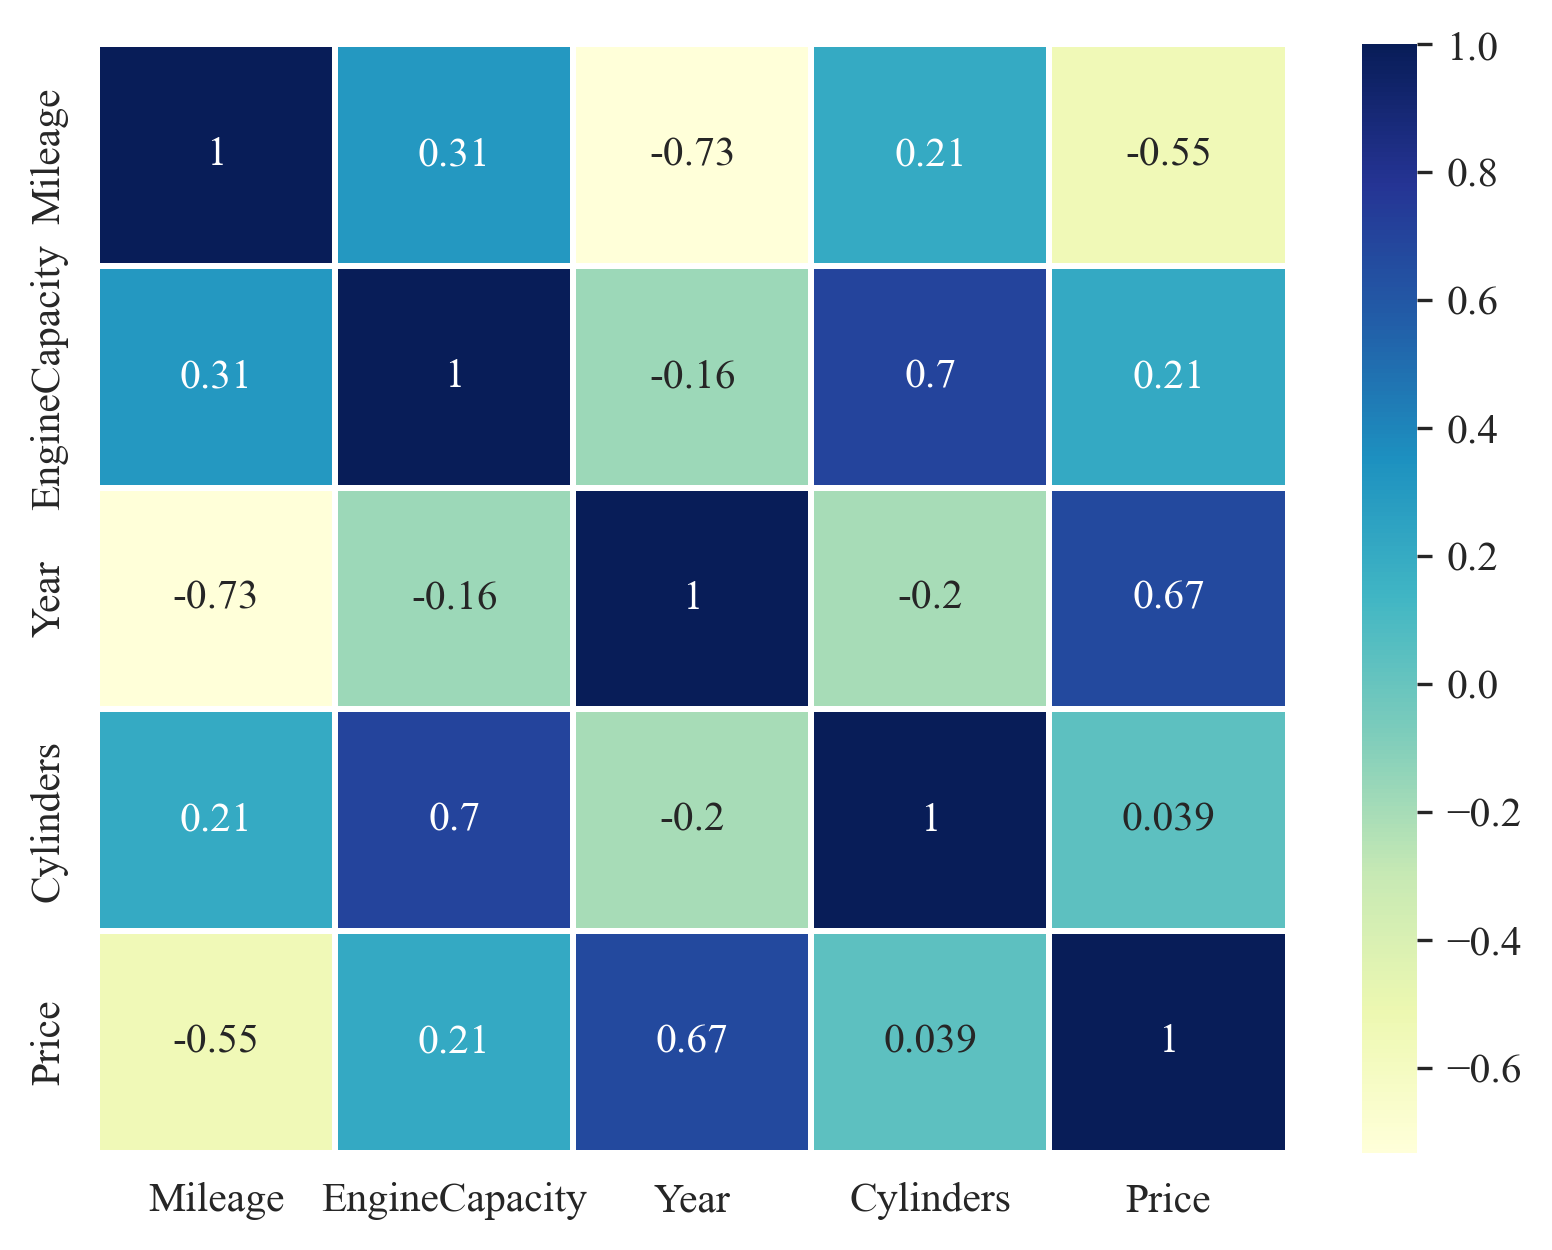

In [14]:
plt.figure(dpi=300)
sns.heatmap(data[['Mileage','EngineCapacity','Year','Cylinders','Price']].corr(), annot=True, linewidth=1, cmap="YlGnBu");

- strong negative relationship between mileage and year.
- good negative relationship between mileage and price.
- strong positive relationship between engine capacity and cylinders.
- strong positive relationship between year and car price.

In [10]:
data.reset_index(drop=True, inplace=True)

&nbsp;

# Preprocessing

### Data Encoding

In [11]:
#Label encoding the variables "Condition" and "Transmission"
data['Condition'] = data['Condition'].replace({'USED':0, 'NEW':1})
data.rename(columns={'Condition': 'New'}, inplace=True)
data['Transmission'] = data['Transmission'].replace({'Manual':0, 'Automatic':1})
data.rename(columns={'Transmission': 'Auto'}, inplace=True)

#One-hot encoding the remaining categorical variables
cat_cols = ['Brand','DriveType','FuelType','BodyType']
cat_data = data[cat_cols].copy()
onehot_encoded_data = pd.get_dummies(cat_data).astype('int')
num_cols = ['Year','New','Auto','EngineCapacity','Mileage','Cylinders','Price']
data_encoded = pd.concat([data[num_cols].drop(columns=['Price']), onehot_encoded_data, data['Price']],
               axis='columns') # Also put 'Price' at the end as it is the response variable

data_encoded.head()

Year New Auto  EngineCapacity  Mileage  Cylinders  Brand_Audi  Brand_BMW  \
0  2022   0    1             1.3     1035          4           0          0   
1  2017   0    1             2.0    67662          4           0          0   
2  2013   0    1             2.0    82012          4           0          0   
3  2014   0    1             1.3    38229          4           0          0   
4  2018   0    1             2.7    16324          4           0          0   

   Brand_Ford  Brand_GWM  ...  BodyType_Convertible  BodyType_Coupe  \
0           0          0  ...                     0               0   
1           0          0  ...                     0               0   
2           0          0  ...                     0               1   
3           0          0  ...                     0               0   
4           0          0  ...                     0               0   

   BodyType_Hatchback  BodyType_Other  BodyType_People Mover  BodyType_SUV  \
0                   0               0                      0             1   
1                   0               0                      0             1   
2                   0               0                      0             0   
3                   1               0                      0             0   
4                   0               0                      0             0   

   BodyType_Sedan  BodyType_Ute Tray  BodyType_Wagon  Price  
0               0                  0               0  34990  
1               0                  0               0  62280  
2               0                  0               0  24888  
3               0                  0               0  17900  
4               0                  0               0  41999  

[5 rows x 48 columns]

### Feature Scaling & Dataset Splitting

In [12]:
#Set seed for reproducibility
seed = 666

#80% train - 20% test splitting
train, test = train_test_split(data_encoded, test_size=.2, random_state=seed)

#Separating the target and input variables
X_train = train.drop(columns=['Price'])
y_train = train['Price']
X_test = test.drop(columns=['Price'])
y_test = test['Price']

#Using column transformer to transform specific columns independently
ct = ColumnTransformer([
    ('scaler', StandardScaler(), ['Year','EngineCapacity','Mileage','Cylinders'])],
                       remainder='passthrough')

#Fit-transform on training data and transform on test data
train_scaled = ct.fit_transform(train)
test_scaled = ct.transform(test)

#Separating scaled input variables
X_train_scaled = train_scaled[:,:-1]
X_test_scaled = test_scaled[:,:-1]

&nbsp;

# 1. Linear Regression

In [18]:
rgr = LinearRegression()

cv_params = {'fit_intercept': [True, False],
                'copy_X': [True, False],
                'positive': [True, False]}

gs = GridSearchCV(estimator=rgr,
                  param_grid=cv_params,
                  scoring=['r2', 'neg_root_mean_squared_error'],
                  refit='r2',
                  cv=4,
                  verbose=1)

gs.fit(X_train_scaled, y_train)

print('best params:',gs.best_params_)
print('best score:',gs.best_score_)

Fitting 4 folds for each of 8 candidates, totalling 32 fits
best params: {'copy_X': True, 'fit_intercept': False, 'positive': False}
best score: 0.7976832213551874


In [19]:
y_test_pred = gs.predict(X_test_scaled)
y_train_pred = gs.predict(X_train_scaled)

print('LR R2 Score Train:',r2_score(y_train, y_train_pred))
print('LR R2 Score Test:',r2_score(y_test, y_test_pred))
print('LR MAE Train:',mean_absolute_error(y_train, y_train_pred))
print('LR MAE Test:',mean_absolute_error(y_test, y_test_pred))
print('LR RMSE Train:',calc_rmse(y_train, y_train_pred))
print('LR RMSE Test:',calc_rmse(y_test, y_test_pred))
print('LR NSE Train:',calc_nse(y_train, y_train_pred))
print('LR NSE Test:',calc_nse(y_test, y_test_pred))
print('LR MAPE Train:',mean_absolute_percentage_error(y_train, y_train_pred))
print('LR MAPE Test:',mean_absolute_percentage_error(y_test, y_test_pred))

LR R2 Score Train: 0.7998241716348331
LR R2 Score Test: 0.7882321149923737
LR MAE Train: 4889.684454027109
LR MAE Test: 4813.313125657001
LR RMSE Train: 6355.656612976891
LR RMSE Test: 6315.282557758401
LR NSE Train: 0.7998241716348331
LR NSE Test: 0.7882321149923737
LR MAPE Train: 0.20190523616859204
LR MAPE Test: 0.1978237899417546


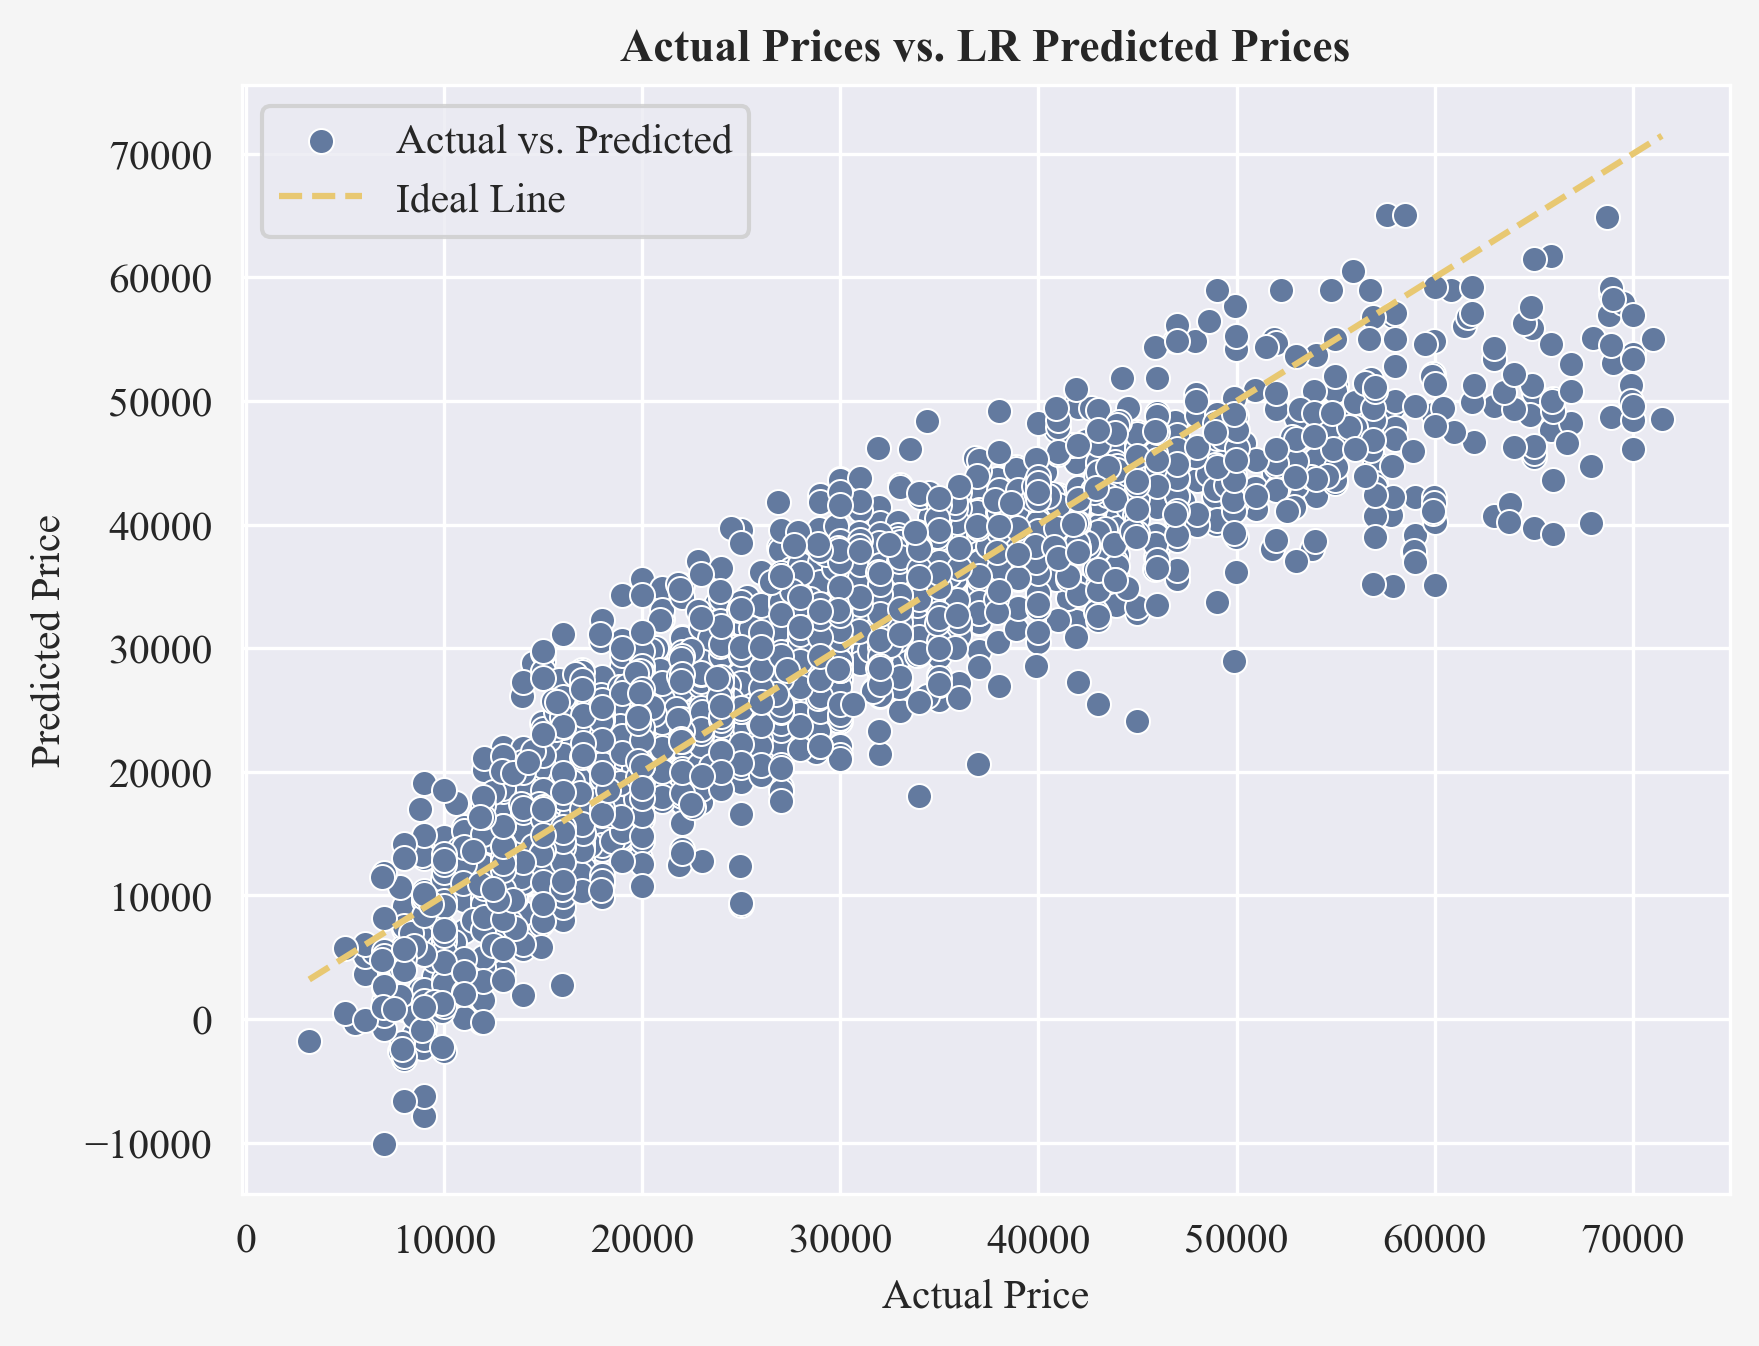

In [20]:
plt.figure(facecolor='whitesmoke', dpi=300)
sns.scatterplot(x=y_test, y=y_test_pred, color='#637A9F', label='Actual vs. Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         '--', color='#E8C872', label='Ideal Line')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual Prices vs. LR Predicted Prices', fontweight='bold', fontsize=11)
plt.legend();

&nbsp;

# 2. Lasso Regression (L1 regularization)

In [37]:
rgr = Lasso(random_state=seed)

cv_params = {'alpha': np.arange(0.1,10,0.1)}

gs = GridSearchCV(estimator=rgr,
                  param_grid=cv_params,
                  scoring=['r2', 'neg_root_mean_squared_error'],
                  refit='r2',
                  cv=4,
                  verbose=1)

gs.fit(X_train_scaled, y_train)

print('best params:',gs.best_params_)
print('best score:',gs.best_score_)

Fitting 4 folds for each of 99 candidates, totalling 396 fits
best params: {'alpha': 0.30000000000000004}
best score: 0.7976895829242412


In [38]:
#Make predictions
y_test_pred = gs.predict(X_test_scaled)
y_train_pred = gs.predict(X_train_scaled)

#Model Evaluation
print('Lasso R2 Score Train:',r2_score(y_train, y_train_pred))
print('Lasso R2 Score Test:',r2_score(y_test, y_test_pred))
print('Lasso MAE Train:',mean_absolute_error(y_train, y_train_pred))
print('Lasso MAE Test:',mean_absolute_error(y_test, y_test_pred))
print('Lasso RMSE Train:',calc_rmse(y_train, y_train_pred))
print('Lasso RMSE Test:',calc_rmse(y_test, y_test_pred))
print('Lasso NSE Train:',calc_nse(y_train, y_train_pred))
print('Lasso NSE Test:',calc_nse(y_test, y_test_pred))
print('Lasso MAPE Train:',mean_absolute_percentage_error(y_train, y_train_pred))
print('Lasso MAPE Test:',mean_absolute_percentage_error(y_test, y_test_pred))

Lasso R2 Score Train: 0.7998210473298257
Lasso R2 Score Test: 0.7882164121120427
Lasso MAE Train: 4889.728165355511
Lasso MAE Test: 4813.49269071522
Lasso RMSE Train: 6355.706211703329
Lasso RMSE Test: 6315.516696867741
Lasso NSE Train: 0.7998210473298257
Lasso NSE Test: 0.7882164121120427
Lasso MAPE Train: 0.20187975072305026
Lasso MAPE Test: 0.1978193918648226


### Features discarded by the model

In [21]:
coef = gs.best_estimator_.coef_
features = X_train.columns

print('Features discarded by the model:')
print(np.array(features)[coef==0])

Features discarded by the model:
['Brand_Mazda']


&nbsp;

# 3. Ridge Regression (L2 regularization)

In [49]:
rgr = Ridge(random_state=seed)

cv_params = {'alpha': np.arange(0.1,3,0.1),
             'fit_intercept':[True,False],
             'copy_X':[True,False]}

gs = GridSearchCV(estimator=rgr,
                  param_grid=cv_params,
                  scoring=['r2', 'neg_root_mean_squared_error'],
                  refit='r2',
                  cv=4,
                  verbose=1)

gs.fit(X_train_scaled, y_train)

print('best params:',gs.best_params_)
print('best score:',gs.best_score_)

Fitting 4 folds for each of 116 candidates, totalling 464 fits
best params: {'alpha': 0.2, 'copy_X': True, 'fit_intercept': False}
best score: 0.7976902807067283


In [50]:
#Make predictions
y_test_pred = gs.predict(X_test_scaled)
y_train_pred = gs.predict(X_train_scaled)

#Model Evaluation
print('Ridge R2 Score Train:',r2_score(y_train, y_train_pred))
print('Ridge R2 Score Test:',r2_score(y_test, y_test_pred))
print('Ridge MAE Train:',mean_absolute_error(y_train, y_train_pred))
print('Ridge MAE Test:',mean_absolute_error(y_test, y_test_pred))
print('Ridge RMSE Train:',calc_rmse(y_train, y_train_pred))
print('Ridge RMSE Test:',calc_rmse(y_test, y_test_pred))
print('Ridge NSE Train:',calc_nse(y_train, y_train_pred))
print('Ridge NSE Test:',calc_nse(y_test, y_test_pred))
print('Ridge MAPE Train:',mean_absolute_percentage_error(y_train, y_train_pred))
print('Ridge MAPE Test:',mean_absolute_percentage_error(y_test, y_test_pred))

Ridge R2 Score Train: 0.7998224637725619
Ridge R2 Score Test: 0.7882065367379595
Ridge MAE Train: 4889.673073175971
Ridge MAE Test: 4813.582983129297
Ridge RMSE Train: 6355.68372554856
Ridge RMSE Test: 6315.663940012265
Ridge NSE Train: 0.7998224637725619
Ridge NSE Test: 0.7882065367379595
Ridge MAPE Train: 0.20189621330586657
Ridge MAPE Test: 0.19781731901800242


In [51]:
print('Number of features discarded:', np.sum(gs.best_estimator_.coef_ == 0))

Number of features discarded: 0


&nbsp;

# 4. Polynomial Linear Regression

In [18]:
#Generate polynomial and interaction features
ply = PolynomialFeatures(degree=3) 
X_train_ply = ply.fit_transform(X_train_scaled)
X_test_ply = ply.transform(X_test_scaled)

#Define regression model
rgr = LinearRegression()
rgr.fit(X_train_ply, y_train)

#Make predictions
y_test_pred = rgr.predict(X_test_ply)
y_train_pred = rgr.predict(X_train_ply)

#Model Evaluation
print('Poly LR R2 Score Train:',r2_score(y_train, y_train_pred))
print('Poly LR R2 Score Test:',r2_score(y_test, y_test_pred))
print('Poly LR MAE Train:',mean_absolute_error(y_train, y_train_pred))
print('Poly LR MAE Test:',mean_absolute_error(y_test, y_test_pred))
print('Poly LR RMSE Train:',calc_rmse(y_train, y_train_pred))
print('Poly LR RMSE Test:',calc_rmse(y_test, y_test_pred))
print('Poly LR NSE Train:',calc_nse(y_train, y_train_pred))
print('Poly LR NSE Test:',calc_nse(y_test, y_test_pred))
print('Poly LR MAPE Train:',mean_absolute_percentage_error(y_train, y_train_pred))
print('Poly LR MAPE Test:',mean_absolute_percentage_error(y_test, y_test_pred))

Poly LR R2 Score Train: 0.9397935977059501
Poly LR R2 Score Test: -1153362819835850.2
Poly LR MAE Train: 2483.0031704896337
Poly LR MAE Test: 38739320945.38856
Poly LR RMSE Train: 3485.5871493047453
Poly LR RMSE Test: 466064163464.7915
Poly LR NSE Train: 0.9397935977059501
Poly LR NSE Test: -1153362819835850.2
Poly LR MAPE Train: 0.09142283082027186
Poly LR MAPE Test: 1361059.2159797868


&nbsp;

# 5. K-Nearest Neighbors

In [13]:
rgr = KNeighborsRegressor()

cv_params = {'n_neighbors': np.linspace(1,50,50).astype('int')}

gs = GridSearchCV(estimator=rgr,
                  param_grid=cv_params,
                  scoring=['r2', 'neg_root_mean_squared_error'],
                  refit='r2',
                  cv=4,
                  verbose=1)

gs.fit(X_train_scaled, y_train)

print(gs.best_params_)
print(gs.best_score_)

Fitting 4 folds for each of 50 candidates, totalling 200 fits
{'n_neighbors': 4}
0.8772968455663186


In [14]:
y_test_pred = gs.predict(X_test_scaled)
y_train_pred = gs.predict(X_train_scaled)

test_r2 = r2_score(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)

print('KNN R2 Score Train:',train_r2)
print('KNN R2 Score Test:',test_r2)
print('KNN MAE Train:',mean_absolute_error(y_train, y_train_pred))
print('KNN MAE Test:',mean_absolute_error(y_test, y_test_pred))
print('KNN RMSE Train:',calc_rmse(y_train, y_train_pred))
print('KNN RMSE Test:',calc_rmse(y_test, y_test_pred))
print('KNN NSE Train:',calc_nse(y_train, y_train_pred))
print('KNN NSE Test:',calc_nse(y_test, y_test_pred))
print('KNN MAPE Train:',mean_absolute_percentage_error(y_train, y_train_pred))
print('KNN MAPE Test:',mean_absolute_percentage_error(y_test, y_test_pred))

KNN R2 Score Train: 0.9346710972794121
KNN R2 Score Test: 0.8863448259012338
KNN MAE Train: 2539.982851786502
KNN MAE Test: 3294.641975308642
KNN RMSE Train: 3630.8414901122546
KNN RMSE Test: 4626.550880341711
KNN NSE Train: 0.9346710972794121
KNN NSE Test: 0.8863448259012338
KNN MAPE Train: 0.09493283051494213
KNN MAPE Test: 0.12508040705593332


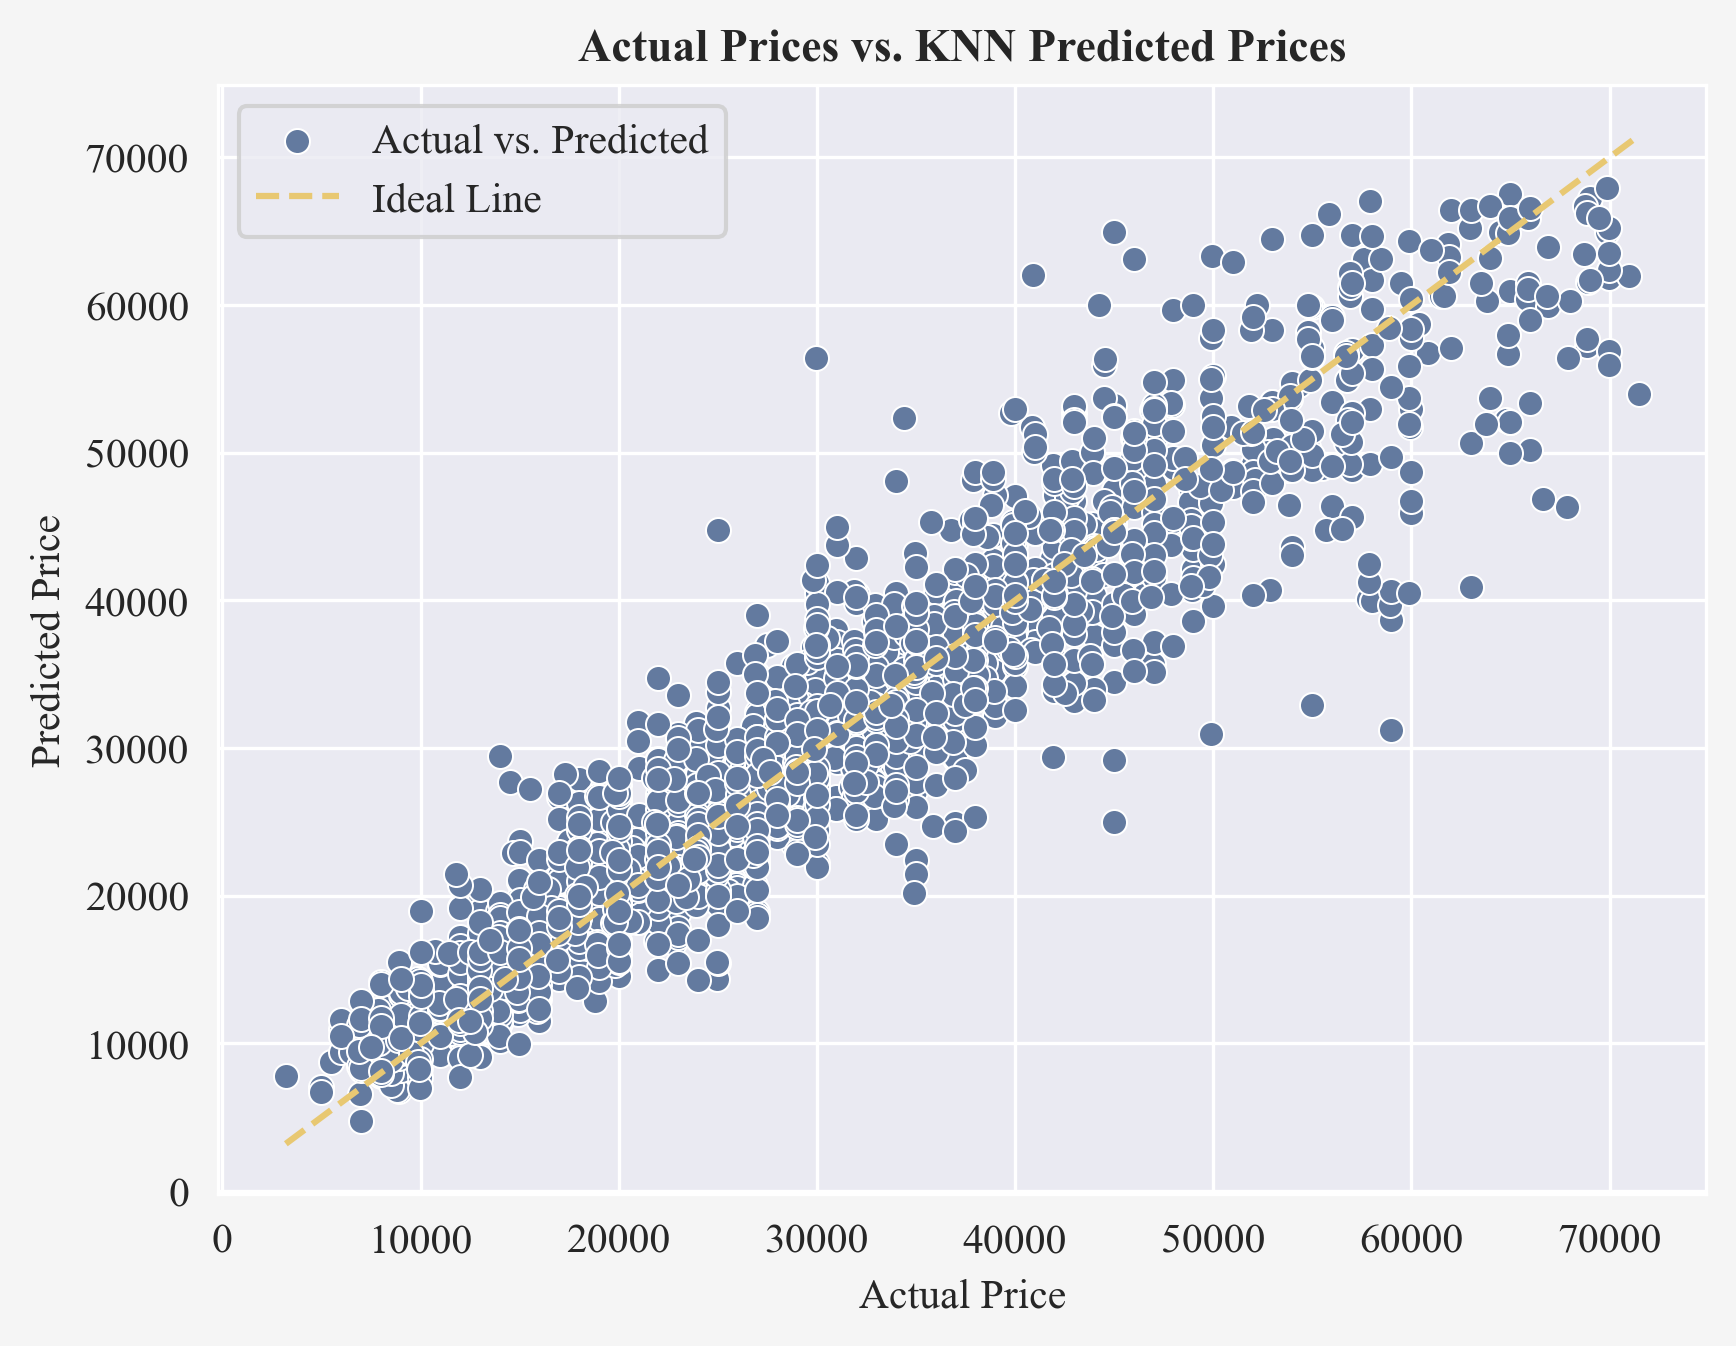

In [15]:
plt.figure(facecolor='whitesmoke', dpi=300)
sns.scatterplot(x=y_test, y=y_test_pred, color='#637A9F', label='Actual vs. Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         '--', color='#E8C872', label='Ideal Line')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual Prices vs. KNN Predicted Prices', fontweight='bold', fontsize=11)
plt.legend();

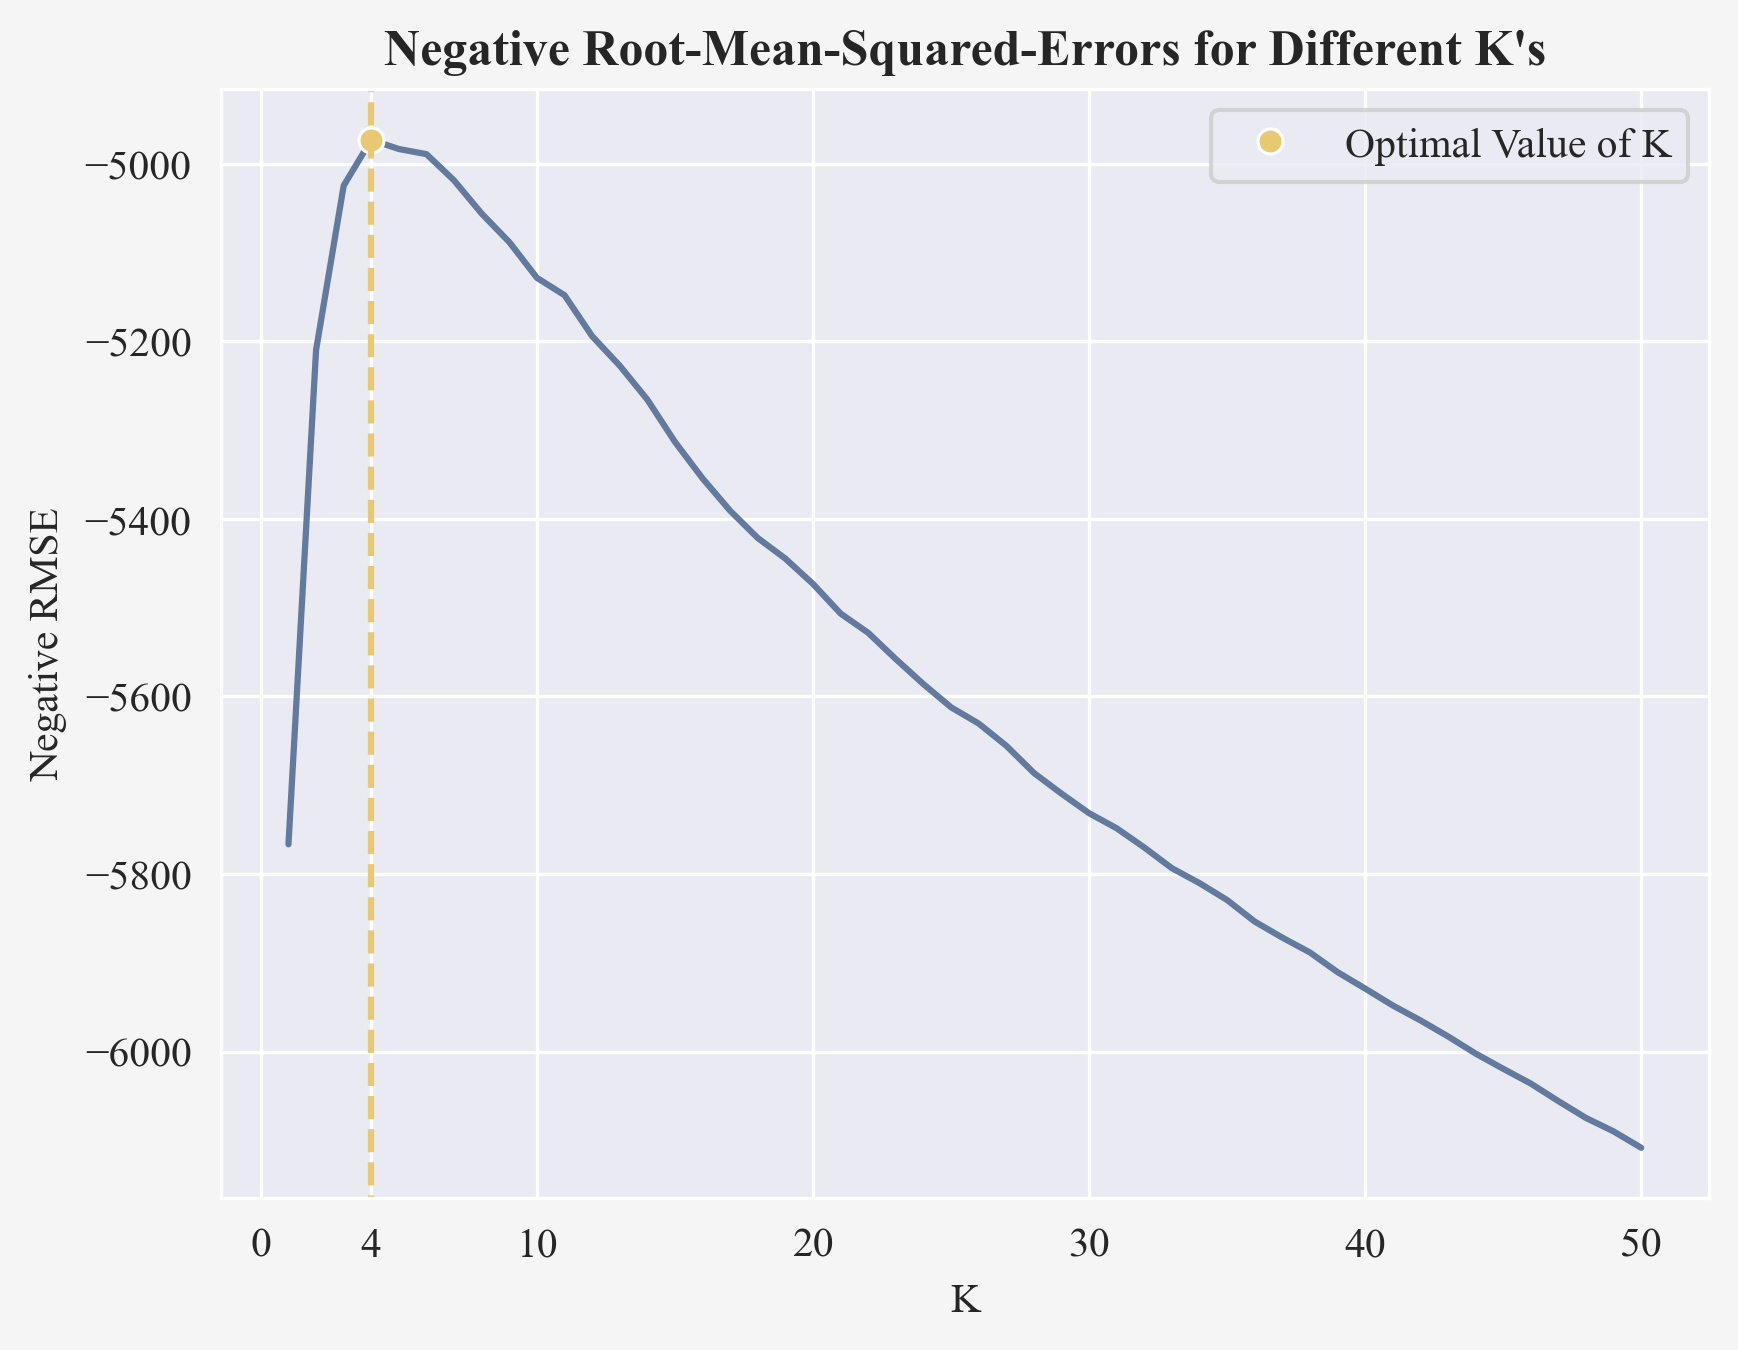

In [167]:
n_neighbors = np.linspace(1,50,50).astype('int')
neg_errors = gs.cv_results_['mean_test_neg_root_mean_squared_error']

plt.figure(facecolor='whitesmoke', dpi=300)
sns.lineplot(x=n_neighbors, y=neg_errors, color='#637A9F')
sns.lineplot(x=gs.best_params_['n_neighbors'],
             y=neg_errors[np.where(n_neighbors==gs.best_params_['n_neighbors'])],
             color='#E8C872', marker='o', linestyle='None', label='Optimal Value of K')
plt.axvline(4,np.min(neg_errors),1, linestyle='--', color='#E8C872')
plt.title('Negative Root-Mean-Squared-Errors for Different K\'s', weight='bold')
plt.xticks([0,gs.best_params_['n_neighbors'],10,20,30,40,50])
plt.xlabel('K')
plt.ylabel('Negative RMSE');

&nbsp;

# 6. Regression Decision-Tree

### Hyperparameter tuning: `max_depth`

In [16]:
cv_params = {'max_depth': np.linspace(1,100,100).astype('int')}

gs = GridSearchCV(estimator=DecisionTreeRegressor(random_state=seed),
                  param_grid=cv_params,
                  scoring=['r2', 'neg_root_mean_squared_error'],
                  refit='r2',
                  cv=4,
                  verbose=1)

gs.fit(X_train_scaled, y_train)

print('best params:',gs.best_params_)
print('best score:',gs.best_score_)

Fitting 4 folds for each of 100 candidates, totalling 400 fits
best params: {'max_depth': 12}
best score: 0.813342628828896


### Hyperparameter tuning: `min_samples_split`

In [17]:
max_depth = gs.best_params_['max_depth']

cv_params = {'min_samples_split': np.linspace(2,40,39).astype('int')}

gs = GridSearchCV(estimator=DecisionTreeRegressor(max_depth=max_depth,
                                                  random_state=seed),
                  param_grid=cv_params,
                  scoring=['r2', 'neg_root_mean_squared_error'],
                  refit='r2',
                  cv=4,
                  verbose=1)

gs.fit(X_train_scaled, y_train)

print('best params:',gs.best_params_)
print('best score:',gs.best_score_)

Fitting 4 folds for each of 39 candidates, totalling 156 fits
best params: {'min_samples_split': 13}
best score: 0.822589002197256


### Hyperparameter tuning: `min_samples_leaf`

In [18]:
min_samples_split = gs.best_params_['min_samples_split']

cv_params = {'min_samples_leaf': np.linspace(1,20,20).astype('int')}

gs = GridSearchCV(estimator=DecisionTreeRegressor(max_depth=max_depth,
                                                  min_samples_split=min_samples_split,
                                                  random_state=seed),
                  param_grid=cv_params,
                  scoring=['r2', 'neg_root_mean_squared_error'],
                  refit='r2',
                  cv=4,
                  verbose=1)

gs.fit(X_train_scaled, y_train)

print('best params:',gs.best_params_)
print('best score:',gs.best_score_)

Fitting 4 folds for each of 20 candidates, totalling 80 fits
best params: {'min_samples_leaf': 3}
best score: 0.8227635476737155


### Hyperparameter tuning: `max_features`

In [19]:
min_samples_leaf = gs.best_params_['min_samples_leaf']

cv_params = {'max_features': list(range(1,X_train_scaled.shape[1]+1))}

gs = GridSearchCV(estimator=DecisionTreeRegressor(max_depth=max_depth,
                                                  min_samples_split=min_samples_split,
                                                  min_samples_leaf=min_samples_leaf,
                                                  random_state=seed),
                  param_grid=cv_params,
                  scoring=['r2', 'neg_root_mean_squared_error'],
                  refit='r2',
                  cv=4,
                  verbose=1)

gs.fit(X_train_scaled, y_train)

print('best params:',gs.best_params_)
print('best score:',gs.best_score_)

Fitting 4 folds for each of 47 candidates, totalling 188 fits
best params: {'max_features': 40}
best score: 0.8249839025895905


In [20]:
y_test_pred = gs.predict(X_test_scaled)
y_train_pred = gs.predict(X_train_scaled)

print('DT R2 Score Train:',r2_score(y_train, y_train_pred))
print('DT R2 Score Test:',r2_score(y_test, y_test_pred))
print('DT MAE Train:',mean_absolute_error(y_train, y_train_pred))
print('DT MAE Test:',mean_absolute_error(y_test, y_test_pred))
print('DT RMSE Train:',calc_rmse(y_train, y_train_pred))
print('DT RMSE Test:',calc_rmse(y_test, y_test_pred))
print('DT NSE Train:',calc_nse(y_train, y_train_pred))
print('DT NSE Test:',calc_nse(y_test, y_test_pred))
print('DT MAPE Train:',mean_absolute_percentage_error(y_train, y_train_pred))
print('DT MAPE Test:',mean_absolute_percentage_error(y_test, y_test_pred))

DT R2 Score Train: 0.9025044472010061
DT R2 Score Test: 0.8198846912488987
DT MAE Train: 3173.844609375895
DT MAE Test: 4141.709437875758
DT RMSE Train: 4435.545214977039
DT RMSE Test: 5824.223741341552
DT NSE Train: 0.9025044472010061
DT NSE Test: 0.8198846912488987
DT MAPE Train: 0.11477959105933103
DT MAPE Test: 0.15349725920779372


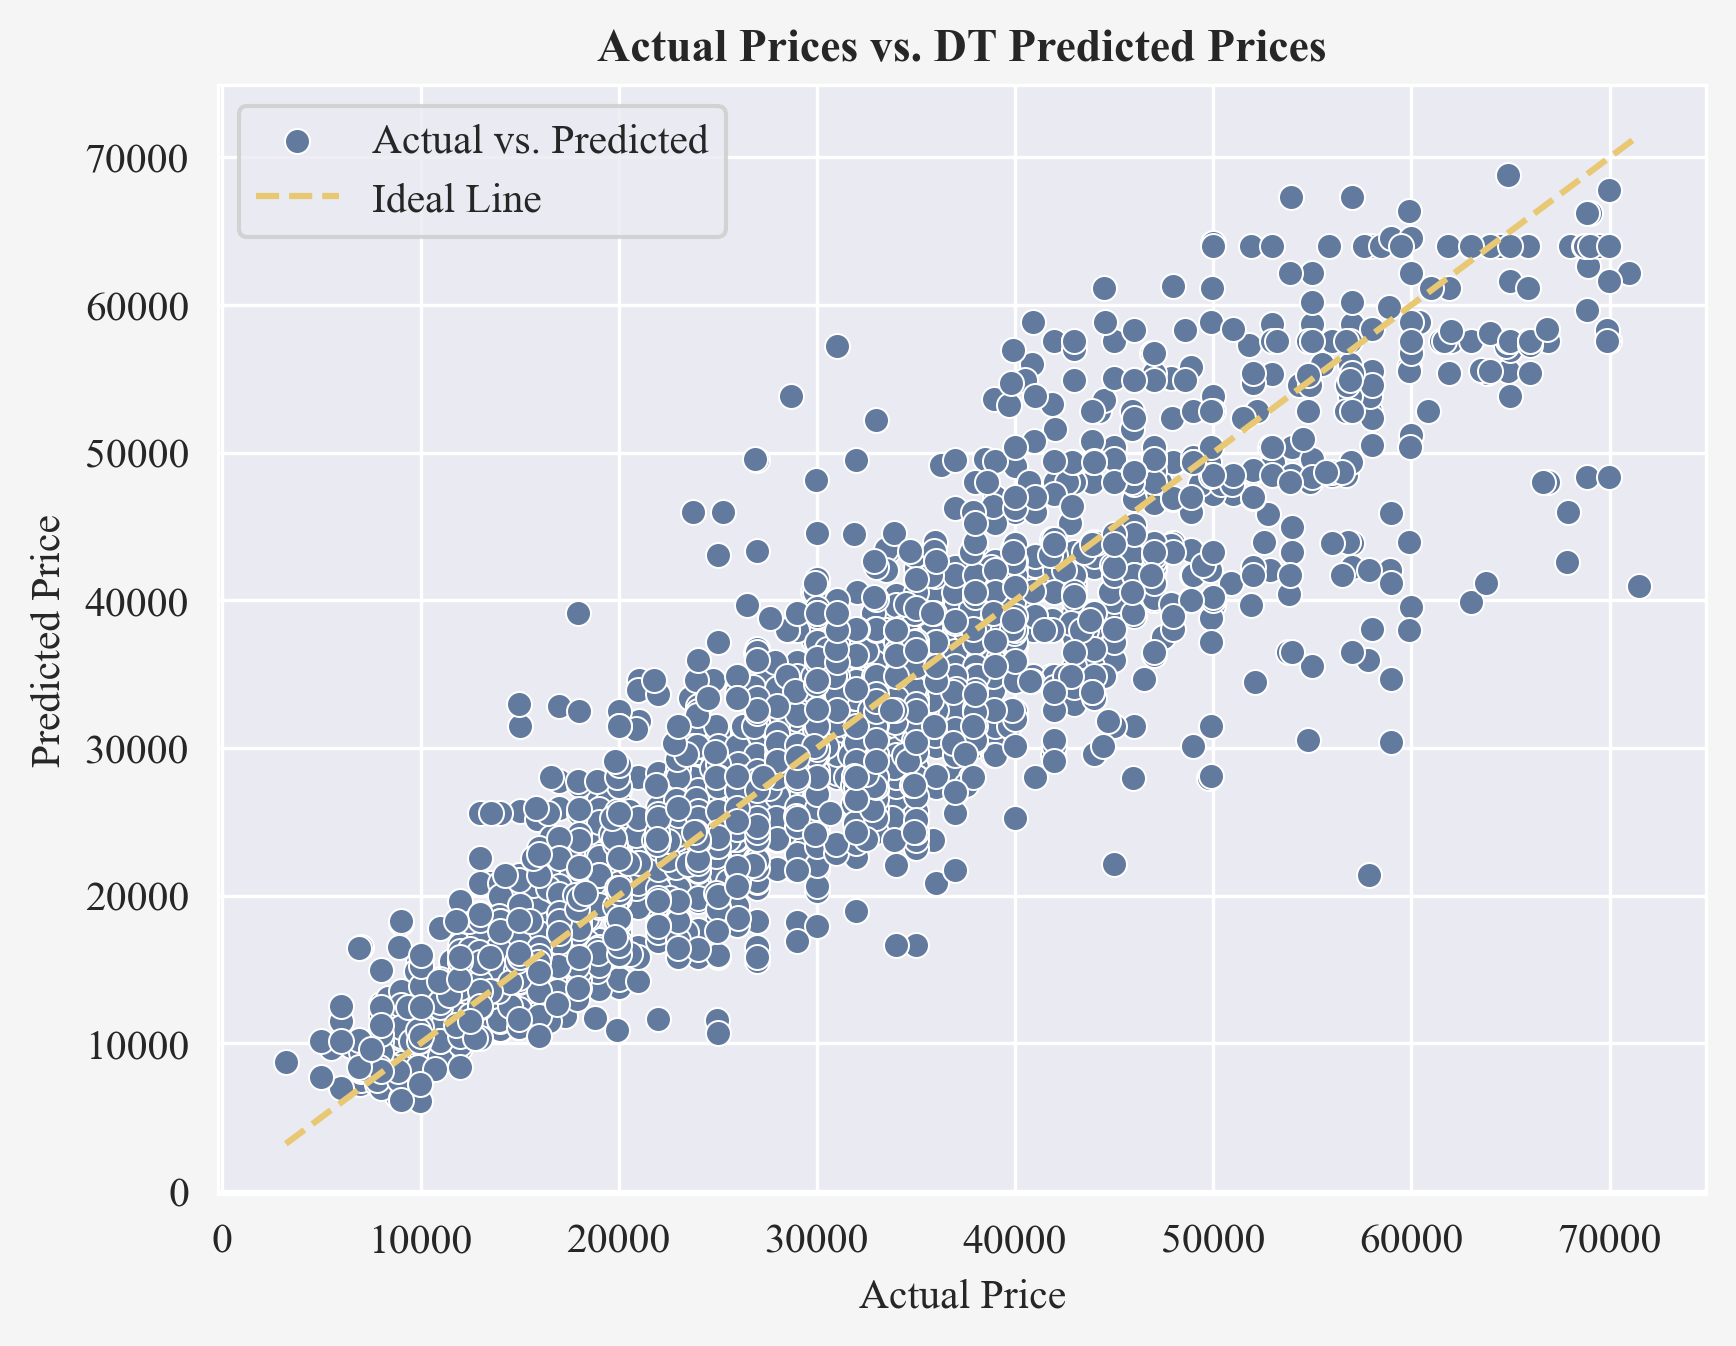

In [21]:
plt.figure(facecolor='whitesmoke', dpi=300)
sns.scatterplot(x=y_test, y=y_test_pred, color='#637A9F', label='Actual vs. Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         '--', color='#E8C872', label='Ideal Line')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual Prices vs. DT Predicted Prices', fontweight='bold', fontsize=11)
plt.legend();

&nbsp;

# 7. Random Forest

### Hyperparameter tuning `n_estimators` on a wide range of values

In [22]:
cv_params = {'n_estimators': np.linspace(10,150,15).astype(int)}

gs = GridSearchCV(estimator=RandomForestRegressor(random_state=seed),
                  param_grid=cv_params,
                  scoring=['r2', 'neg_root_mean_squared_error'],
                  refit='r2',
                  cv=4,
                  verbose=1)

gs.fit(X_train_scaled, y_train)

print('best params:',gs.best_params_)
print('best score:',gs.best_score_)

Fitting 4 folds for each of 15 candidates, totalling 60 fits
best params: {'n_estimators': 130}
best score: 0.8829773316877991


### Refine `n_estimators` with a smaller grid of values

In [23]:
n_estimators = gs.best_params_['n_estimators']

cv_params = {'n_estimators': np.linspace(n_estimators-5,n_estimators+5,10).astype(int)}

gs = GridSearchCV(estimator=RandomForestRegressor(random_state=seed),
                  param_grid=cv_params,
                  scoring=['r2', 'neg_root_mean_squared_error'],
                  refit='r2',
                  cv=4,
                  verbose=1)

gs.fit(X_train_scaled, y_train)

print('best params:',gs.best_params_)
print('best score:',gs.best_score_)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
best params: {'n_estimators': 131}
best score: 0.8829969479360061


### Hyperparameter tuning: `min_samples_split`

In [24]:
n_estimators = gs.best_params_['n_estimators']

cv_params = {'min_samples_split': np.linspace(2,10,9).astype(int)}

gs = GridSearchCV(estimator=RandomForestRegressor(n_estimators=n_estimators,
                                                  random_state=seed),
                  param_grid=cv_params,
                  scoring=['r2', 'neg_root_mean_squared_error'],
                  refit='r2',
                  cv=4,
                  verbose=1)

gs.fit(X_train_scaled, y_train)

print('best params:',gs.best_params_)
print('best score:',gs.best_score_)

Fitting 4 folds for each of 9 candidates, totalling 36 fits
best params: {'min_samples_split': 5}
best score: 0.8846070245789235


### Hyperparameter tuning: `max_features`

In [25]:
min_samples_split = gs.best_params_['min_samples_split']

cv_params = {'max_features': list(range(1, X_train_scaled.shape[1] + 1))}

gs = GridSearchCV(estimator=RandomForestRegressor(n_estimators=n_estimators,
                                                  min_samples_split=min_samples_split,
                                                  random_state=seed),
                  param_grid=cv_params,
                  scoring=['r2', 'neg_root_mean_squared_error'],
                  refit='r2',
                  cv=4,
                  verbose=1)

gs.fit(X_train_scaled, y_train)

print('best params:',gs.best_params_)
print('best score:',gs.best_score_)

Fitting 4 folds for each of 47 candidates, totalling 188 fits
best params: {'max_features': 10}
best score: 0.8980330672303599


### Fitting the best model with the training set

In [26]:
y_test_pred = gs.predict(X_test_scaled)
y_train_pred = gs.predict(X_train_scaled)

print('RF R2 Score Train:',r2_score(y_train, y_train_pred))
print('RF R2 Score Test:',r2_score(y_test, y_test_pred))
print('RF MAE Train:',mean_absolute_error(y_train, y_train_pred))
print('RF MAE Test:',mean_absolute_error(y_test, y_test_pred))
print('RF RMSE Train:',calc_rmse(y_train, y_train_pred))
print('RF RMSE Test:',calc_rmse(y_test, y_test_pred))
print('RF NSE Train:',calc_nse(y_train, y_train_pred))
print('RF NSE Test:',calc_nse(y_test, y_test_pred))
print('RF MAPE Train:',mean_absolute_percentage_error(y_train, y_train_pred))
print('RF MAPE Test:',mean_absolute_percentage_error(y_test, y_test_pred))

RF R2 Score Train: 0.9641178922227671
RF R2 Score Test: 0.8993181240393593
RF MAE Train: 1930.268082748463
RF MAE Test: 3139.9293966326504
RF RMSE Train: 2690.8753532617416
RF RMSE Test: 4354.500917266788
RF NSE Train: 0.9641178922227671
RF NSE Test: 0.8993181240393593
RF MAPE Train: 0.0720966493568881
RF MAPE Test: 0.11941805196125349


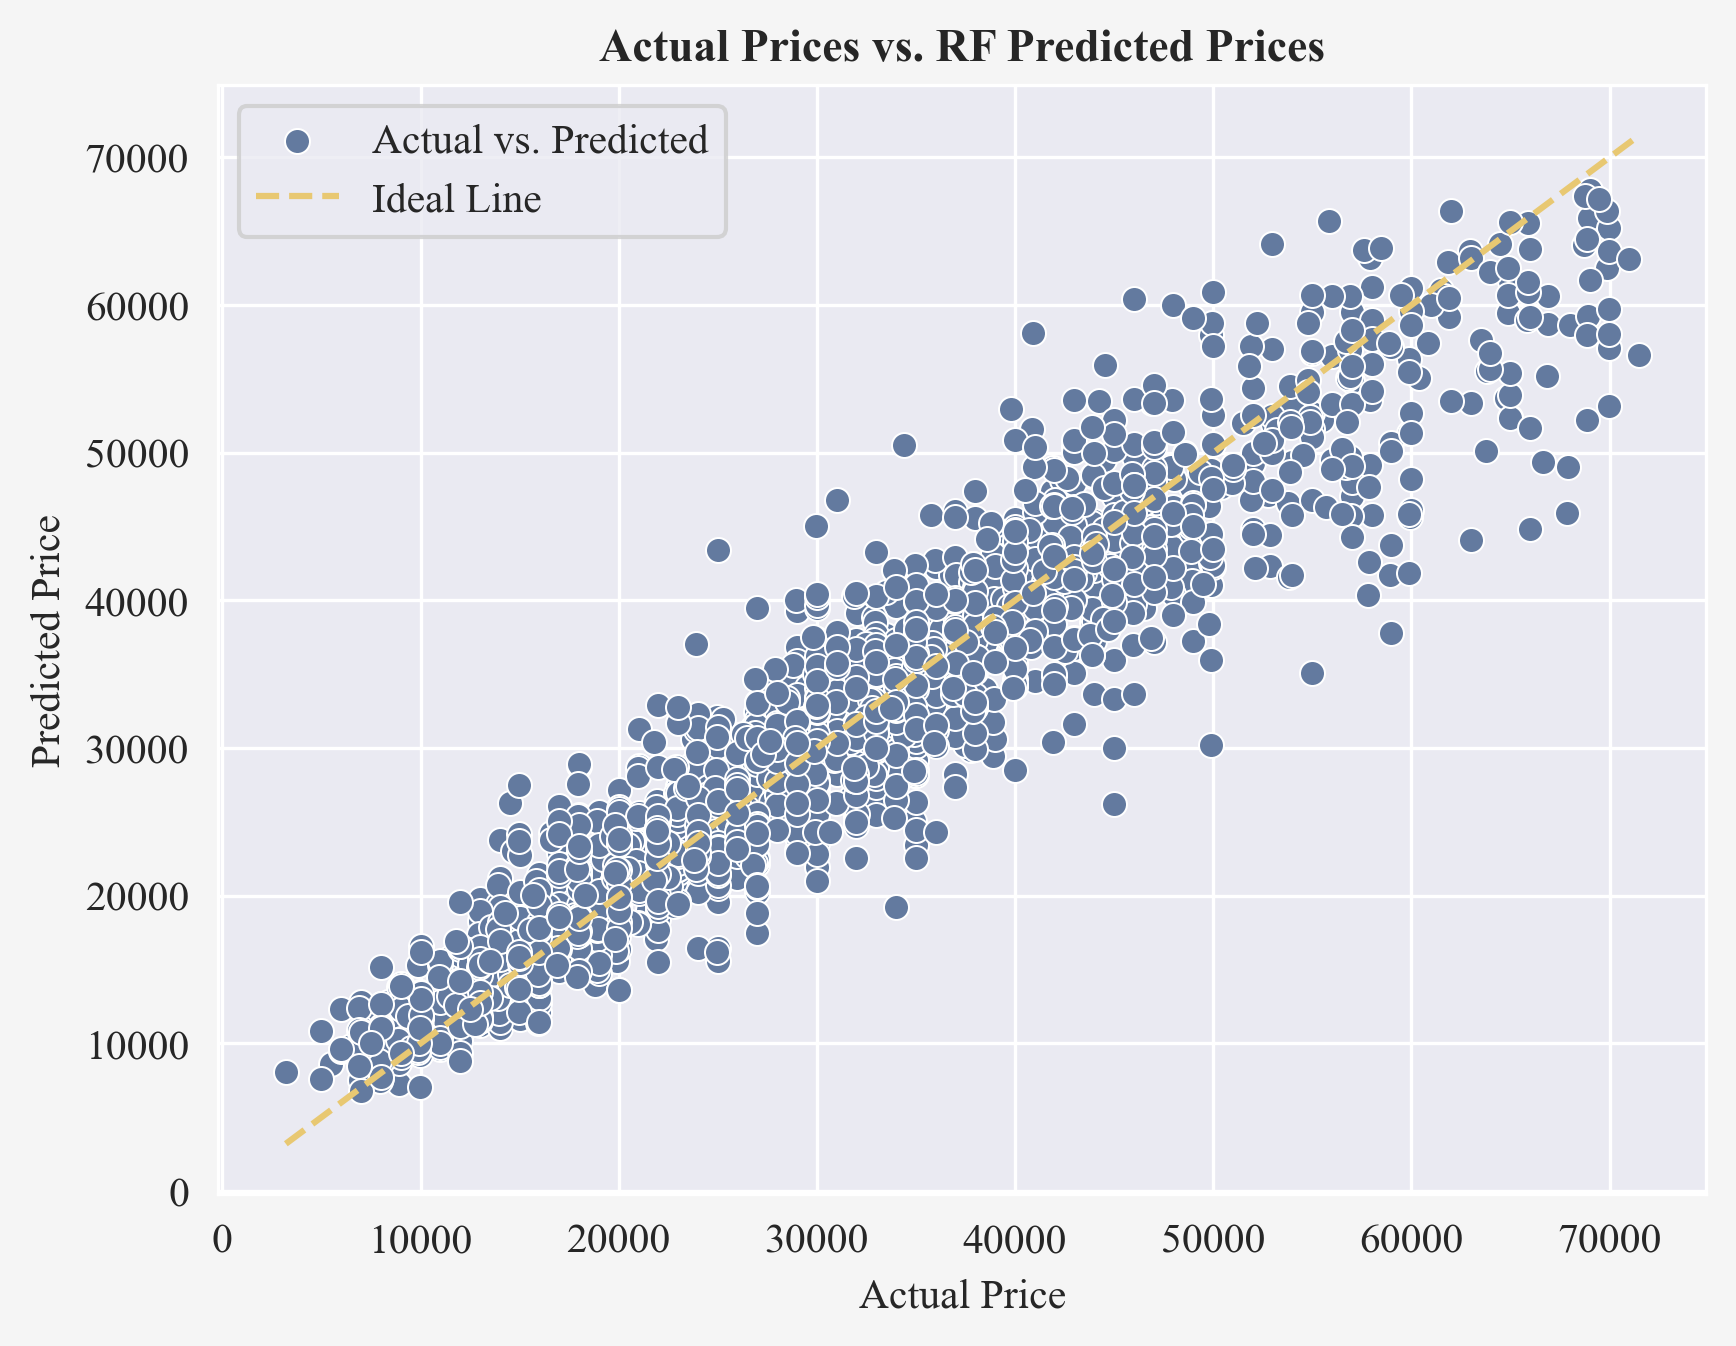

In [27]:
plt.figure(facecolor='whitesmoke', dpi=300)
sns.scatterplot(x=y_test, y=y_test_pred, color='#637A9F', label='Actual vs. Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         '--', color='#E8C872', label='Ideal Line')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual Prices vs. RF Predicted Prices', fontweight='bold', fontsize=11)
plt.legend();

&nbsp;

# 8. eXtreme Gradient Boosting

### tune the `max_depth` and `min_child_weight` on a wide range of values

In [16]:
cv_params = {'max_depth': [2,4,6,8],
             'min_child_weight': [1,3,5,7]}

gs = GridSearchCV(estimator=xgb.XGBRegressor(random_state=seed),
                  param_grid=cv_params,
                  scoring=['r2', 'neg_root_mean_squared_error'],
                  refit='r2',
                  cv=4,
                  verbose=1)

gs.fit(X_train_scaled, y_train)

print('best params:',gs.best_params_)
print('best score:',gs.best_score_)

Fitting 4 folds for each of 16 candidates, totalling 64 fits
best params: {'max_depth': 6, 'min_child_weight': 1}
best score: 0.9008945033487794


### Refine `max_depth` and `min_child_weight` on a smaller grid of values

In [17]:
max_depth = gs.best_params_['max_depth']
min_child_weight = gs.best_params_['min_child_weight']

cv_params = {'max_depth': [max_depth-1, max_depth, max_depth+1], 
             'min_child_weight': [min_child_weight-1, min_child_weight-0.5, min_child_weight, min_child_weight+0.5, min_child_weight+1]}

gs = GridSearchCV(estimator=xgb.XGBRegressor(random_state=seed),
                  param_grid=cv_params,
                  scoring=['r2', 'neg_root_mean_squared_error'],
                  refit='r2',
                  cv=4,
                  verbose=1)

gs.fit(X_train_scaled, y_train)

print('best params:',gs.best_params_)
print('best score:',gs.best_score_)

Fitting 4 folds for each of 15 candidates, totalling 60 fits
best params: {'max_depth': 6, 'min_child_weight': 0}
best score: 0.9008945033487794


### Hyperparameter tuning `gamma`

In [18]:
max_depth = gs.best_params_['max_depth']
min_child_weight = gs.best_params_['min_child_weight']

cv_params = {'gamma': [i/10.0 for i in range(1,10,2)]}

gs = GridSearchCV(estimator=xgb.XGBRegressor(max_depth=max_depth,
                                             min_child_weight=min_child_weight,
                                             random_state=seed),
                  param_grid=cv_params,
                  scoring=['r2', 'neg_root_mean_squared_error'],
                  refit='r2',
                  cv=4,
                  verbose=1)

gs.fit(X_train_scaled, y_train)

print('best params:',gs.best_params_)
print('best score:',gs.best_score_)

Fitting 4 folds for each of 5 candidates, totalling 20 fits
best params: {'gamma': 0.1}
best score: 0.9008945033487794


### tune both `colsample_bytree` and `subsample` on 10% intervals from 60% to 100%

In [19]:
gamma = gs.best_params_['gamma']

cv_params = {'subsample': [i/10.0 for i in range(6,11)],
             'colsample_bytree': [i/10.0 for i in range(6,11)]}

gs = GridSearchCV(estimator=xgb.XGBRegressor(max_depth=max_depth,
                                             min_child_weight=min_child_weight,
                                             gamma=gamma,
                                             random_state=seed),
                  param_grid=cv_params,
                  scoring=['r2', 'neg_root_mean_squared_error'],
                  refit='r2',
                  cv=4,
                  verbose=1)

gs.fit(X_train_scaled, y_train)

print('best params:',gs.best_params_)
print('best score:',gs.best_score_)

Fitting 4 folds for each of 25 candidates, totalling 100 fits
best params: {'colsample_bytree': 0.7, 'subsample': 0.9}
best score: 0.9024316206687217


### Retune `colsample_bytree` and `subsample` with a smaller grid of values

In [20]:
subsample = gs.best_params_['subsample']
colsample_bytree = gs.best_params_['colsample_bytree']

cv_params = {'subsample': [i/100.0 for i in range(int((subsample-0.1)*100.0), min(int((subsample+0.1)*100),105) , 5)],
             'colsample_bytree': [i/100.0 for i in range(int((colsample_bytree-0.1)*100.0), min(int((subsample+0.1)*100),105), 5)]}

gs = GridSearchCV(estimator=xgb.XGBRegressor(max_depth=max_depth,
                                             min_child_weight=min_child_weight,
                                             gamma=gamma,
                                             random_state=seed),
                  param_grid=cv_params,
                  scoring=['r2', 'neg_root_mean_squared_error'],
                  refit='r2',
                  cv=4,
                  verbose=1)

gs.fit(X_train_scaled, y_train)

print('best params:',gs.best_params_)
print('best score:',gs.best_score_)

Fitting 4 folds for each of 32 candidates, totalling 128 fits
best params: {'colsample_bytree': 0.65, 'subsample': 0.95}
best score: 0.9026479503556821


### tuning `reg_alpha` and `reg_lambda` parameters

`reg_alpha` controls L1 regularisation and `reg_lambda` controls L2 regularisation.

In [21]:
subsample = gs.best_params_['subsample']
colsample_bytree = gs.best_params_['colsample_bytree']

cv_params = {'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100], 
             'reg_lambda': [1e-5, 1e-2, 0.1, 1, 100]}

gs = GridSearchCV(estimator=xgb.XGBRegressor(max_depth=max_depth,
                                             min_child_weight=min_child_weight,
                                             gamma=gamma,
                                             subsample=subsample,
                                             colsample_bytree=colsample_bytree,
                                             random_state=seed),
                  param_grid=cv_params,
                  scoring=['r2', 'neg_root_mean_squared_error'],
                  refit='r2',
                  cv=4,
                  verbose=1)

gs.fit(X_train_scaled, y_train)

print('best params:',gs.best_params_)
print('best score:',gs.best_score_)

Fitting 4 folds for each of 25 candidates, totalling 100 fits
best params: {'reg_alpha': 100, 'reg_lambda': 1}
best score: 0.9040870357295455


### Refine `reg_alpha` and `reg_lambda` on a smaller grid of values

In [22]:
reg_alpha = gs.best_params_['reg_alpha']
reg_lambda = gs.best_params_['reg_lambda']

cv_params = {'reg_alpha': [reg_alpha*0.2, reg_alpha*0.5, reg_alpha, reg_alpha*2, reg_alpha*5], 
             'reg_lambda': [reg_lambda*0.2, reg_lambda*0.5, reg_lambda, reg_lambda*2, reg_lambda*5]}

gs = GridSearchCV(estimator=xgb.XGBRegressor(max_depth=max_depth,
                                             min_child_weight=min_child_weight,
                                             gamma=gamma,
                                             subsample=subsample,
                                             colsample_bytree=colsample_bytree,
                                             random_state=seed),
                  param_grid=cv_params,
                  scoring=['r2', 'neg_root_mean_squared_error'],
                  refit='r2',
                  cv=4,
                  verbose=1)

gs.fit(X_train_scaled, y_train)

print('best params:',gs.best_params_)
print('best score:',gs.best_score_)

Fitting 4 folds for each of 25 candidates, totalling 100 fits
best params: {'reg_alpha': 20.0, 'reg_lambda': 1}
best score: 0.9041250270562236


### Setting regularisation parameters

In [23]:
reg_alpha = gs.best_params_['reg_alpha']
reg_lambda = gs.best_params_['reg_lambda']

parameters = {'max_depth': max_depth,
              'min_child_weight': min_child_weight,
              'gamma': gamma,
              'subsample': subsample,
              'colsample_bytree': colsample_bytree,
              'reg_alpha': reg_alpha,
              'reg_lambda': reg_lambda,
              'random_state': seed}

### Storing input data in a `DMatrix` object

In [24]:
train_DMatrix = xgb.DMatrix(data = X_train_scaled, label = y_train)
test_DMatrix = xgb.DMatrix(data = X_test_scaled, label = y_test)

### tuning `num_boost_round`

number of trees to build will be passed as a standalone argument to the training method.

In [49]:
learning_rate = 0.05
parameters['eta'] = learning_rate

num_boost_round = 3000
early_stopping_rounds = 20

xgbCV = xgb.cv(
    params = parameters, 
    dtrain = train_DMatrix, 
    num_boost_round = num_boost_round,
    nfold = 4,
    metrics = {'rmse'},
    early_stopping_rounds = early_stopping_rounds,
    verbose_eval = 0,
    seed = seed     
)

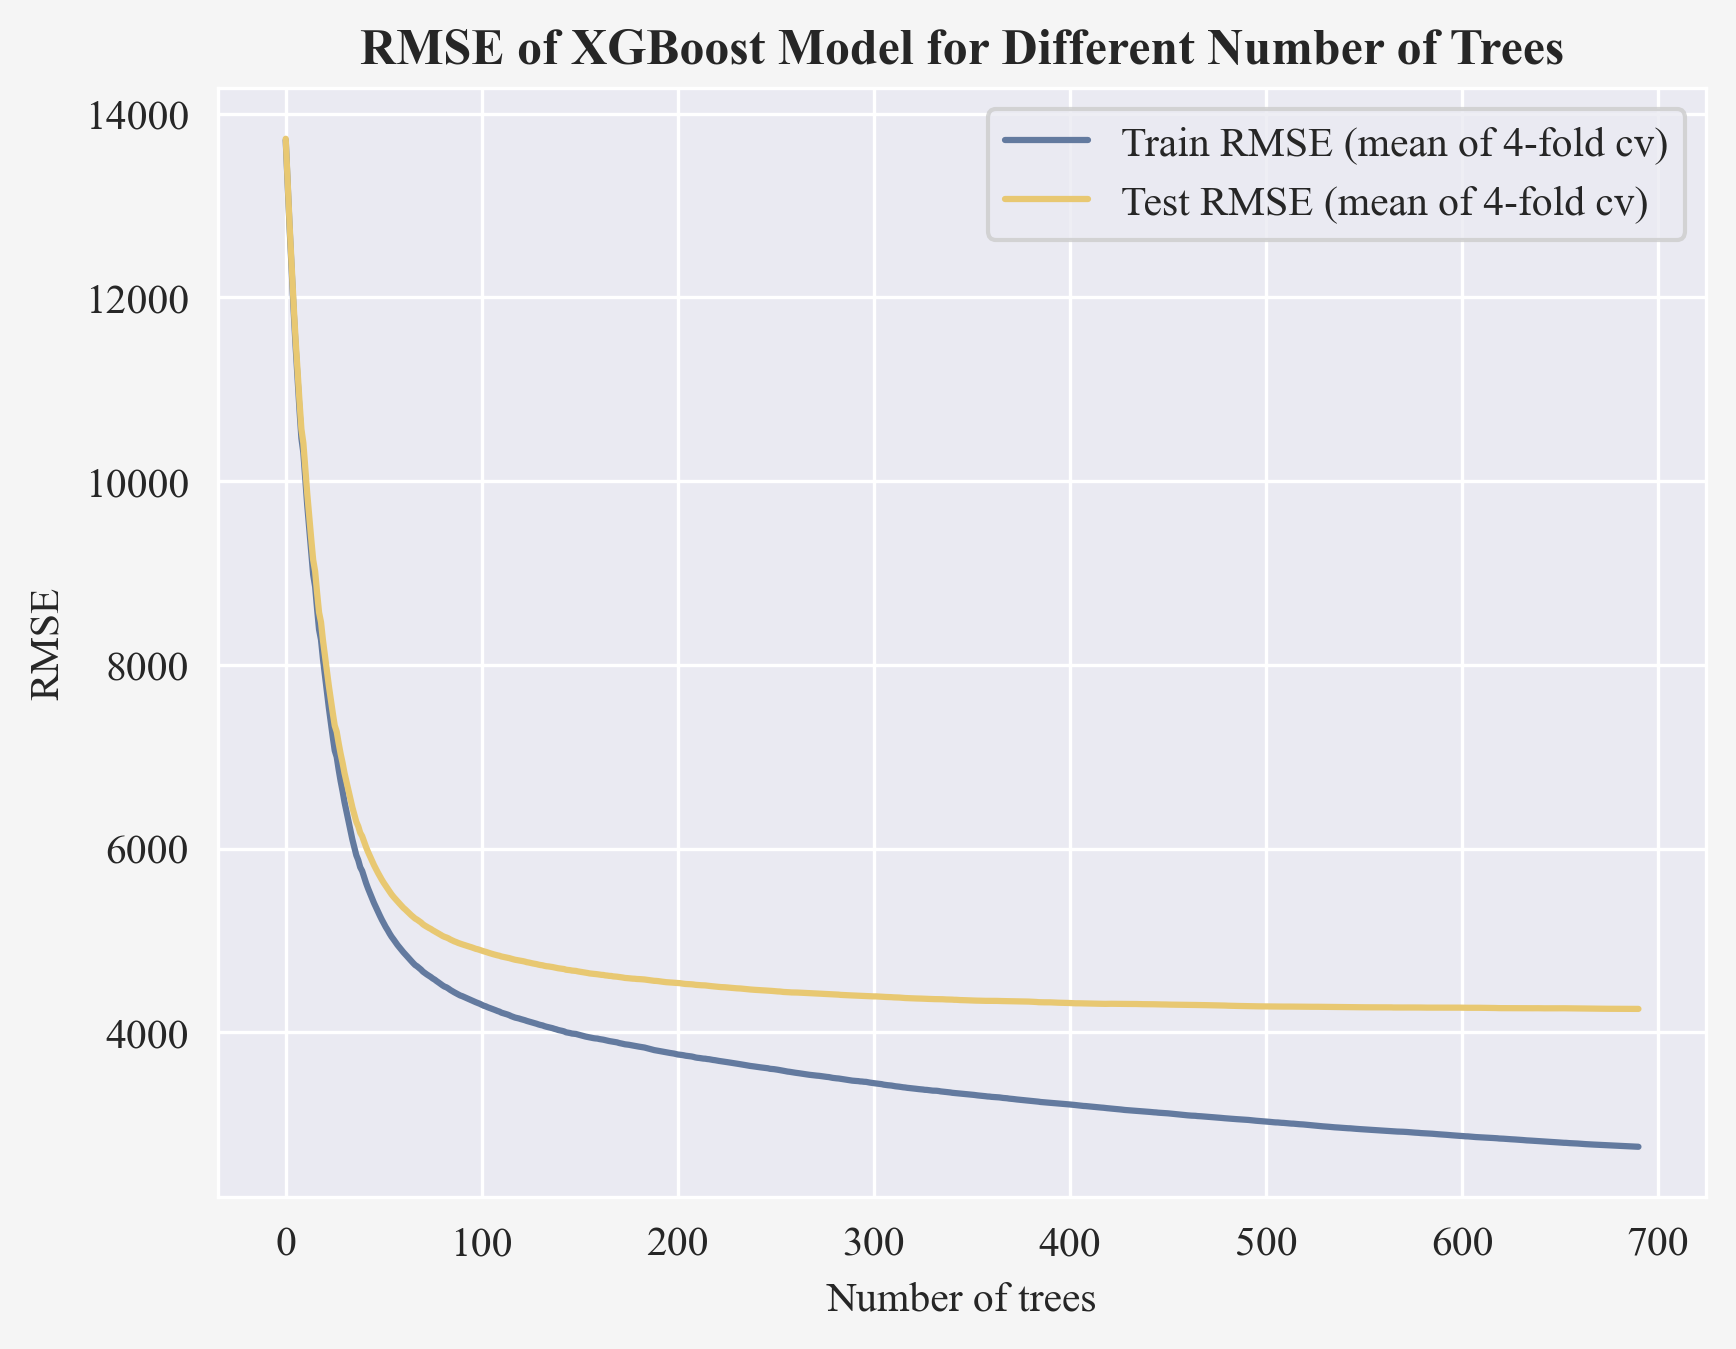

In [50]:
plt.figure(facecolor='whitesmoke', dpi=300)
sns.lineplot(xgbCV['train-rmse-mean'], label='Train RMSE (mean of 4-fold cv)', color='#637A9F')
sns.lineplot(xgbCV['test-rmse-mean'], label='Test RMSE (mean of 4-fold cv)', color='#E8C872')
plt.title('RMSE of XGBoost Model for Different Number of Trees', weight='bold')
plt.xlabel('Number of trees')
plt.ylabel('RMSE');

In [51]:
num_boost_round = len(xgbCV)
parameters['eval_metric'] = 'rmse'

rgr = xgb.train(
    params = parameters, 
    dtrain = train_DMatrix, 
    num_boost_round = num_boost_round,
    evals = [(train_DMatrix, 'train'), 
             (test_DMatrix, 'eval')],
    verbose_eval = 0
)

In [56]:
y_test_pred = rgr.predict(test_DMatrix)
y_train_pred = rgr.predict(train_DMatrix)

print('XGBOOST R2 Score Train:',r2_score(y_train, y_train_pred))
print('XGBOOST R2 Score Test:',r2_score(y_test, y_test_pred))
print('XGBOOST MAE Train:',mean_absolute_error(y_train, y_train_pred))
print('XGBOOST MAE Test:',mean_absolute_error(y_test, y_test_pred))
print('XGBOOST RMSE Train:',calc_rmse(y_train, y_train_pred))
print('XGBOOST RMSE Test:',calc_rmse(y_test, y_test_pred))
print('XGBOOST NSE Train:',calc_nse(y_train, y_train_pred))
print('XGBOOST NSE Test:',calc_nse(y_test, y_test_pred))
print('XGBOOST MAPE Train:',mean_absolute_percentage_error(y_train, y_train_pred))
print('XGBOOST MAPE Test:',mean_absolute_percentage_error(y_test, y_test_pred))

XGBOOST R2 Score Train: 0.9571785872652134
XGBOOST R2 Score Test: 0.9104124650890556
XGBOOST MAE Train: 2161.8521757592807
XGBOOST MAE Test: 3017.1489774512233
XGBOOST RMSE Train: 2939.578777127151
XGBOOST RMSE Test: 4107.584725758642
XGBOOST NSE Train: 0.9571785872652134
XGBOOST NSE Test: 0.9104124650890556
XGBOOST MAPE Train: 0.08037684622979067
XGBOOST MAPE Test: 0.11197937971166398


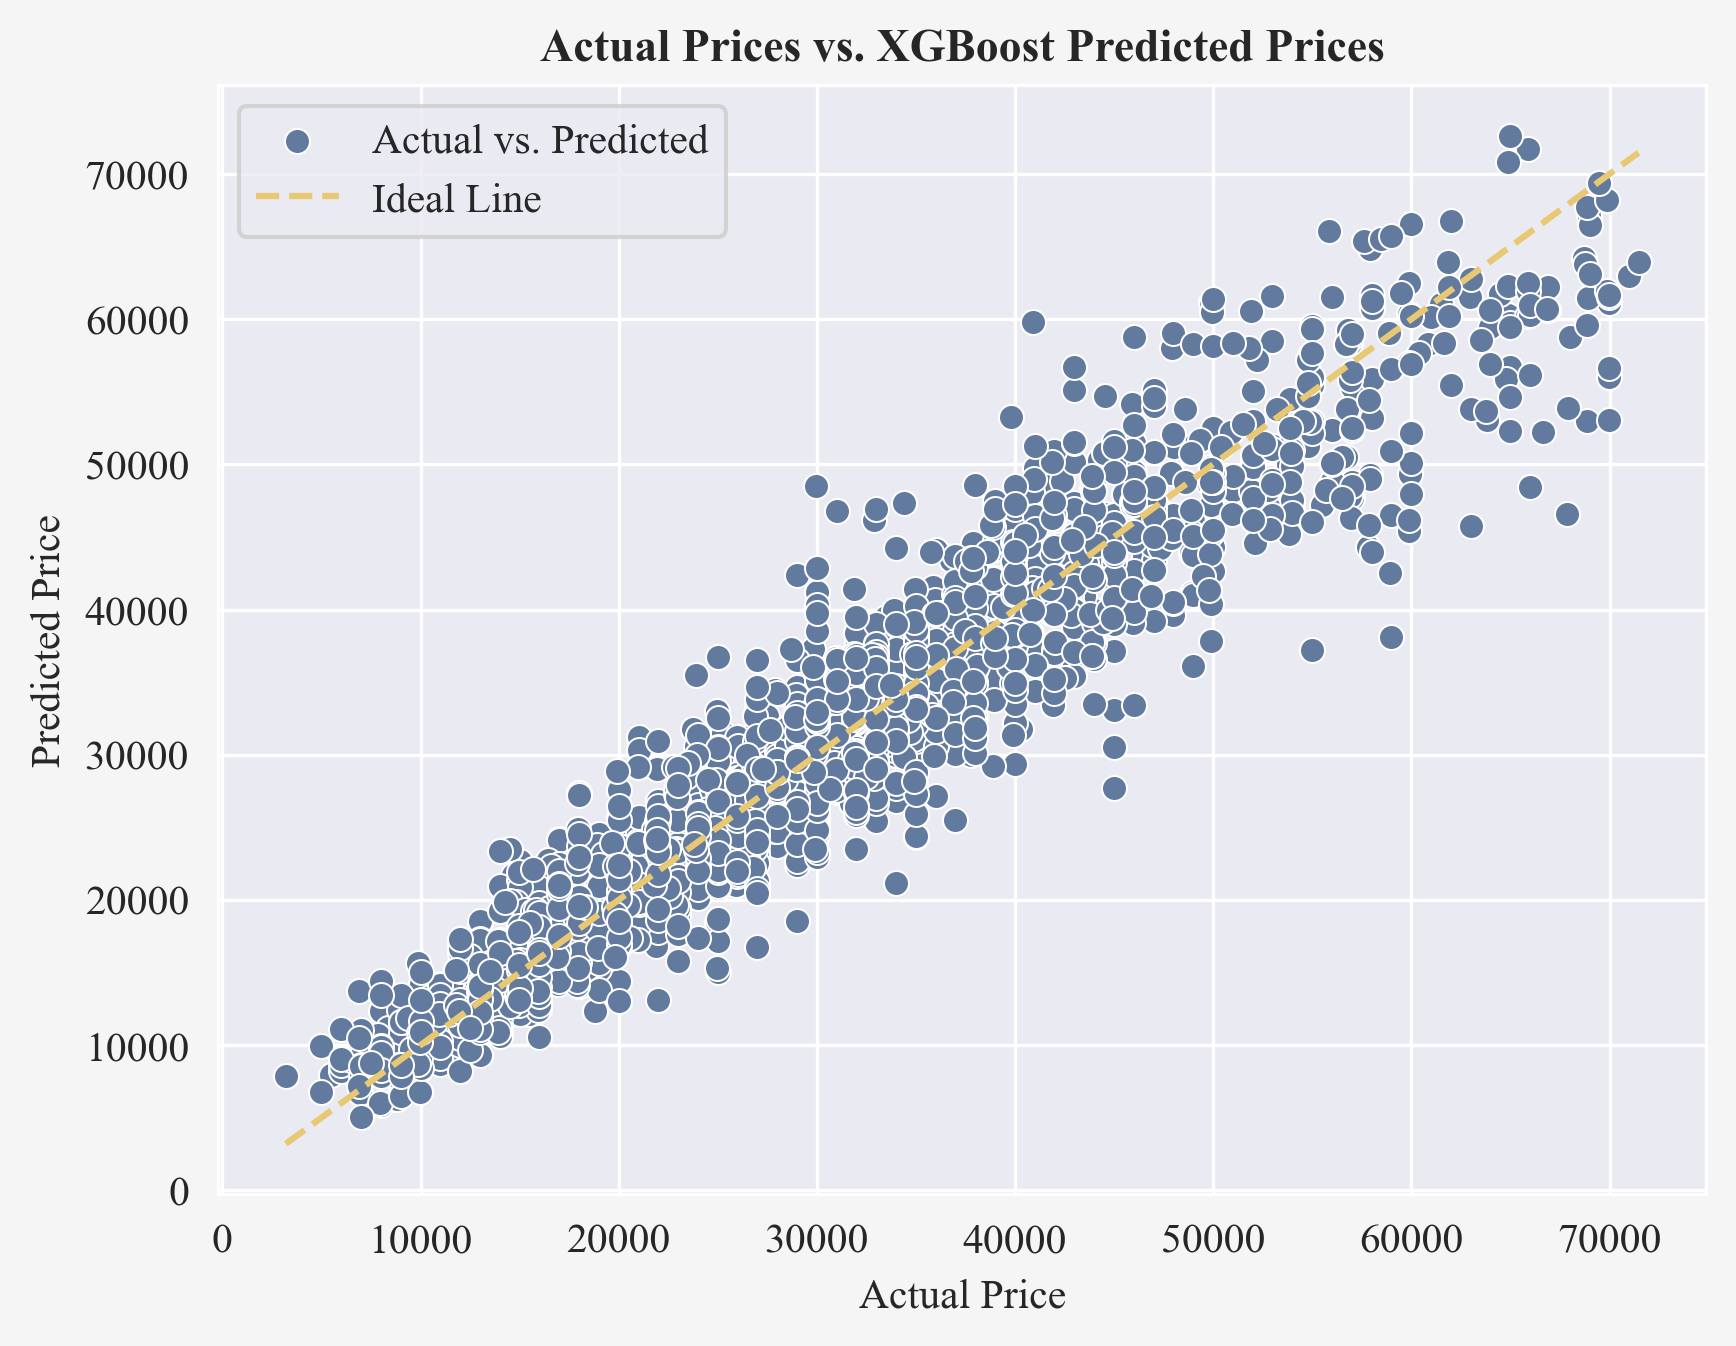

In [60]:
plt.figure(facecolor='whitesmoke', dpi=300)
sns.scatterplot(x=y_test, y=y_test_pred, color='#637A9F', label='Actual vs. Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         '--', color='#E8C872', label='Ideal Line')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual Prices vs. XGBoost Predicted Prices', fontweight='bold', fontsize=11)
plt.legend();

&nbsp;

# 10. Multilayer Perceptron

### Basic hyperparameter tuning with keras `RandomSearch`

In [24]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Dense(hp.Int('units',
                                  min_value=32,
                                  max_value=512,
                                  step=128),
                           activation='relu',
                           input_dim=X_train_scaled.shape[1]))
    model.add(layers.Dense(1))
    opt = keras.optimizers.Adam(hp.Choice('learning_rate',
                                          values=[1e-2, 1e-3, 1e-4]))
    model.compile(optimizer=opt, loss='mse')
    return model

rs = RandomSearch(build_model,
                  objective='val_loss',
                  max_trials=6,
                  executions_per_trial=5,
                  directory='cv_reports',
                  project_name='MLP')

rs.search_space_summary()

Reloading Tuner from cv_reports\MLP\tuner0.json
Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 128, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.0001], 'ordered': True}


In [25]:
rs.search(X_train_scaled[:int(np.round(X_train_scaled.shape[0] * 0.8))],
             y_train[:int(np.round(y_train.shape[0] * 0.8))],
             epochs=200,
             validation_data=(X_train_scaled[int(np.round(X_train_scaled.shape[0] * 0.8)):],
                              y_train[int(np.round(y_train.shape[0] * 0.8)):]))

Trial 6 Complete [00h 00m 01s]

Best val_loss So Far: 22004360.0
Total elapsed time: 02h 01m 14s


In [26]:
rs.results_summary()

Results summary
Results in cv_reports\MLP
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 4 summary
Hyperparameters:
units: 288
learning_rate: 0.01
Score: 22004360.0

Trial 3 summary
Hyperparameters:
units: 160
learning_rate: 0.01
Score: 23241557.666666668

Trial 2 summary
Hyperparameters:
units: 32
learning_rate: 0.01
Score: 27640100.333333332

Trial 0 summary
Hyperparameters:
units: 416
learning_rate: 0.01
Traceback (most recent call last):
  File "C:\Users\NiC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\NiC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 265, in _run_and_update_trial
    tuner_utils.convert_to_metrics_dict(
  File "C:\Users\NiC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras_tuner\src\engine\tuner_utils

### Finalise MLP model

In [69]:
#Best values from RandomSearch results
units = 288
learning_rate = 0.01

#Ensure data is fed in expected format
X_train_scaled = np.asarray(X_train_scaled).astype('float32')
X_test_scaled = np.asarray(X_test_scaled).astype('float32')

#Define model
model = keras.Sequential()
model.add(layers.Dense(units, activation='relu', input_dim=X_train_scaled.shape[1]))
model.add(layers.Dense(1))
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=opt)

#Fit model
history = model.fit(X_train_scaled, y_train, epochs=200, validation_split=.2, verbose=0)

#Make predictions
y_test_pred = model.predict(X_test_scaled)
y_test_pred = y_test_pred.reshape((X_test_scaled.shape[0],))
y_train_pred = model.predict(X_train_scaled)
y_train_pred = y_train_pred.reshape((X_train_scaled.shape[0],))

print('MLP R2 Score Train:',r2_score(y_train, y_train_pred))
print('MLP R2 Score Test:',r2_score(y_test, y_test_pred))
print('MLP MAE Train:',mean_absolute_error(y_train, y_train_pred))
print('MLP MAE Test:',mean_absolute_error(y_test, y_test_pred))
print('MLP RMSE Train:',calc_rmse(y_train, y_train_pred))
print('MLP RMSE Test:',calc_rmse(y_test, y_test_pred))
print('MLP NSE Train:',calc_nse(y_train, y_train_pred))
print('MLP NSE Test:',calc_nse(y_test, y_test_pred))
print('MLP MAPE Train:',mean_absolute_percentage_error(y_train, y_train_pred))
print('MLP MAPE Test:',mean_absolute_percentage_error(y_test, y_test_pred))

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step
MLP R2 Score Train: 0.8995791040379639
MLP R2 Score Test: 0.8798284089688493
MLP MAE Train: 3269.0004534963264
MLP MAE Test: 3471.059149632799
MLP RMSE Train: 4501.597423775272
MLP RMSE Test: 4757.333992067225
MLP NSE Train: 0.8995791040379639
MLP NSE Test: 0.8798284089688493
MLP MAPE Train: 0.11764181971308978
MLP MAPE Test: 0.12688838506168892


### MLP loss curve for training and validation sets

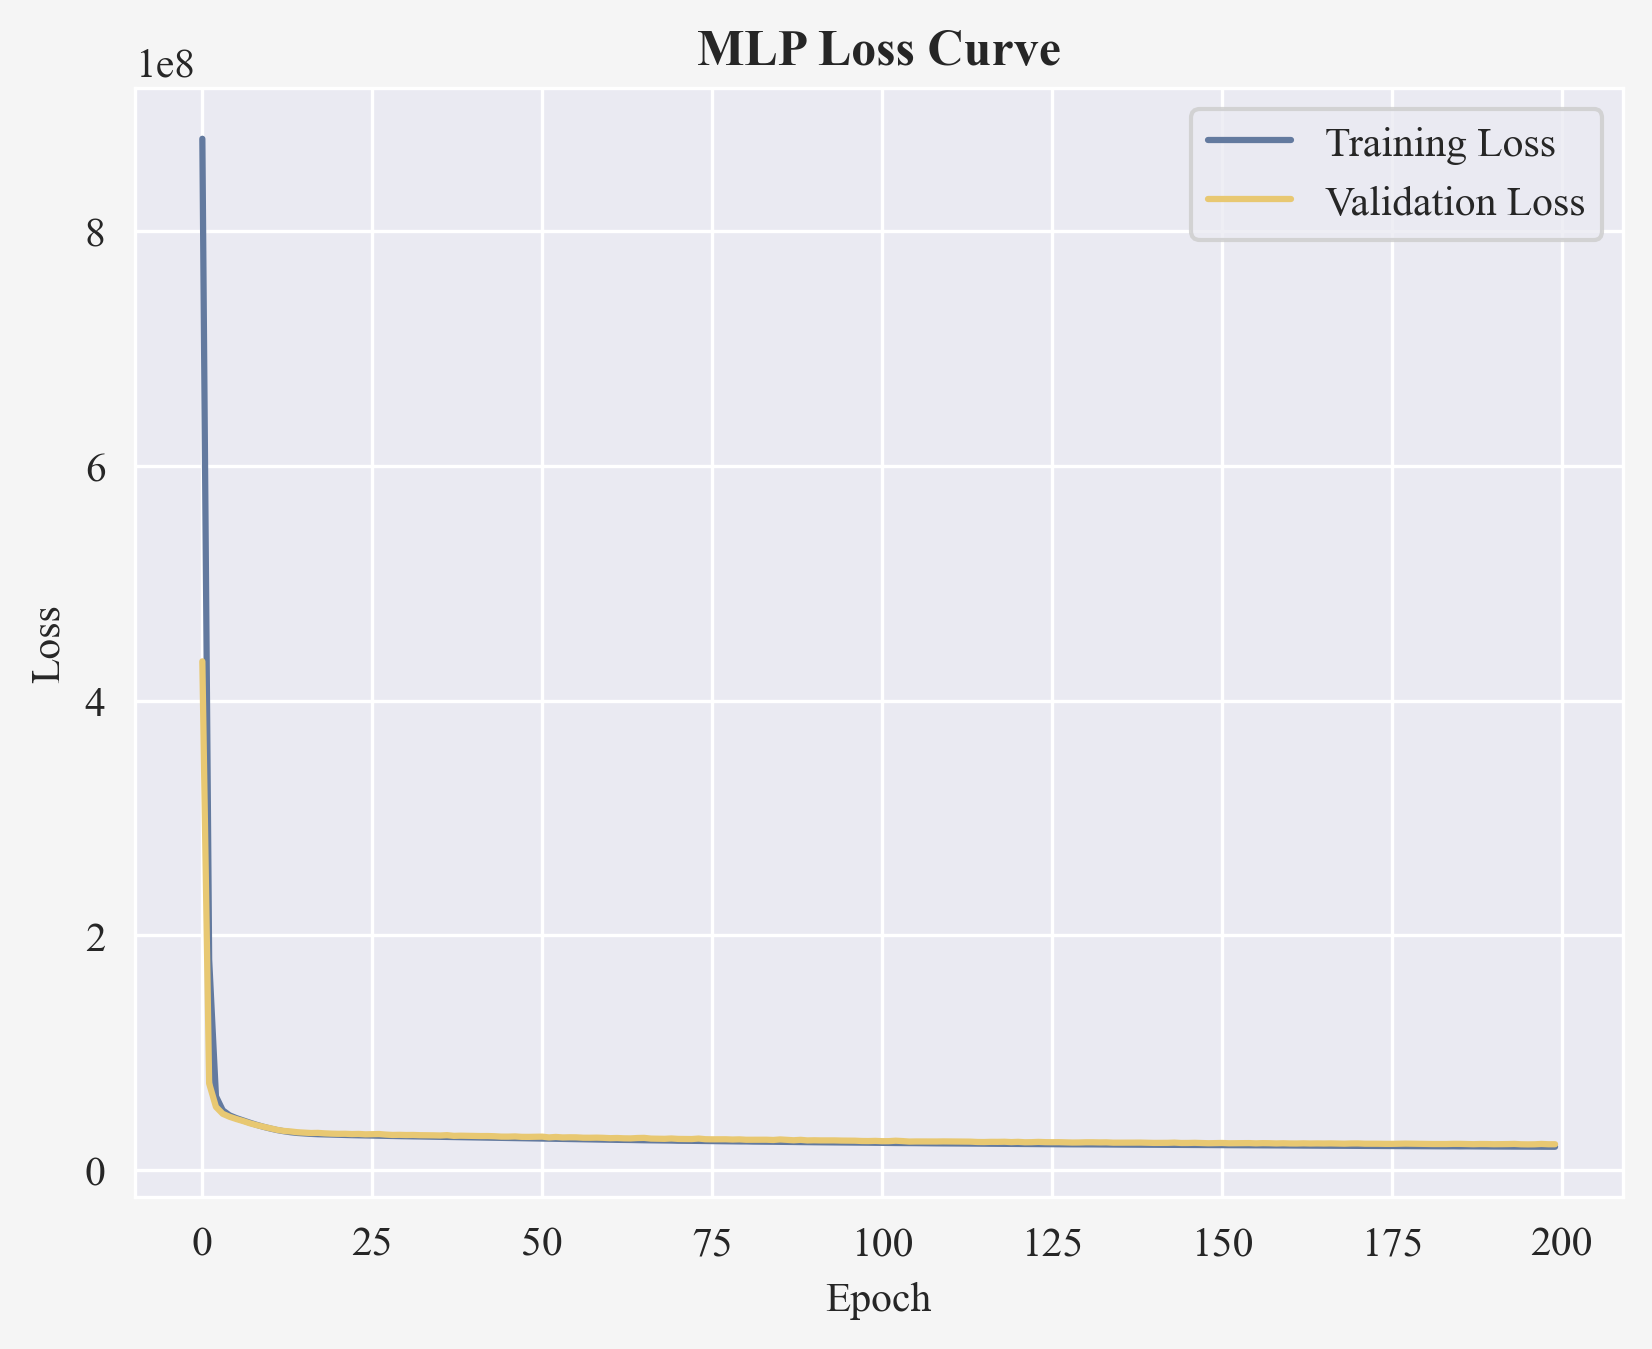

In [77]:
plt.figure(facecolor='whitesmoke', dpi=300)
sns.lineplot(history.history['loss'], label='Training Loss', color='#637A9F')
sns.lineplot(history.history['val_loss'], label='Validation Loss', color='#E8C872')
plt.title('MLP Loss Curve', weight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss');

The loss value for both the training and validation sets is close to each other, so it can be said that the model is neither overfitting nor underfitting.

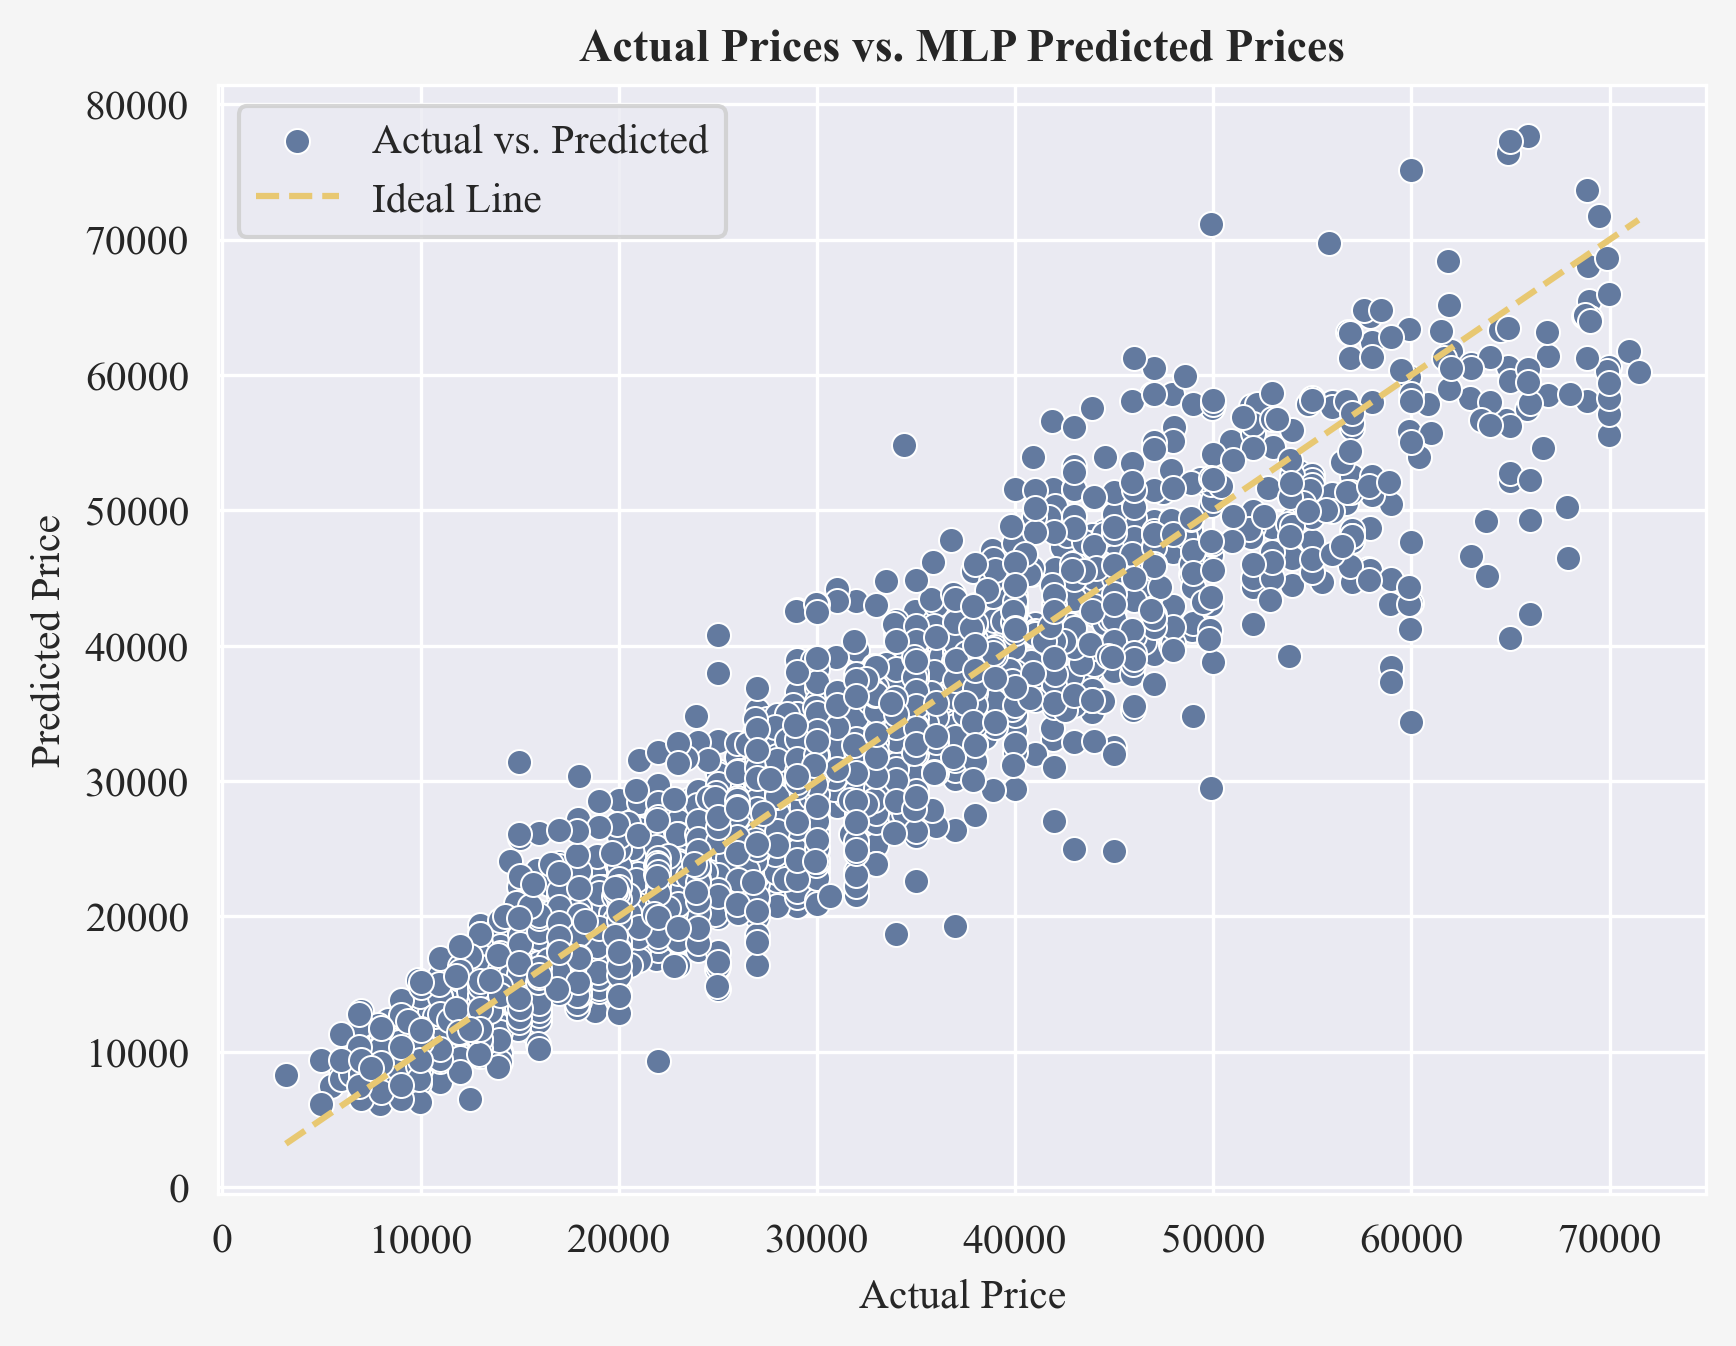

In [70]:
plt.figure(facecolor='whitesmoke', dpi=300)
sns.scatterplot(x=y_test, y=y_test_pred, color='#637A9F', label='Actual vs. Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         '--', color='#E8C872', label='Ideal Line')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual Prices vs. MLP Predicted Prices', fontweight='bold', fontsize=11)
plt.legend();

&nbsp;

# 11. Long Short-Term Memory

In [13]:
#Ensure data is fed in expected format
X_train_scaled = np.asarray(X_train_scaled).astype('float32')
X_test_scaled = np.asarray(X_test_scaled).astype('float32')
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
y_train = np.array(y_train).reshape((y_train.shape[0], 1, 1))
y_test = np.array(y_test).reshape((y_test.shape[0], 1, 1))

#Define model
model = keras.Sequential()
model.add(layers.LSTM(50, return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
model.add(layers.LSTM(50, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

#Fit model
history = model.fit(X_train_scaled, y_train, epochs=200, validation_split=.2, verbose=0)

#Make predictions
y_test_pred = model.predict(X_test_scaled)
y_test = y_test.reshape(y_test.shape[0], y_test.shape[2])
y_train_pred = model.predict(X_train_scaled)
y_train = y_train.reshape(y_train.shape[0], y_train.shape[2])

print('LSTM R2 Score Train:',r2_score(y_train, y_train_pred))
print('LSTM R2 Score Test:',r2_score(y_test, y_test_pred))
print('LSTM MAE Train:',mean_absolute_error(y_train, y_train_pred))
print('LSTM MAE Test:',mean_absolute_error(y_test, y_test_pred))
print('LSTM RMSE Train:',calc_rmse(y_train, y_train_pred))
print('LSTM RMSE Test:',calc_rmse(y_test, y_test_pred))
print('LSTM NSE Train:',calc_nse(y_train, y_train_pred))
print('LSTM NSE Test:',calc_nse(y_test, y_test_pred))
print('LSTM MAPE Train:',mean_absolute_percentage_error(y_train, y_train_pred))
print('LSTM MAPE Test:',mean_absolute_percentage_error(y_test, y_test_pred))

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
LSTM R2 Score Train: 0.94105149988078
LSTM R2 Score Test: 0.9062999631712545
LSTM MAE Train: 2444.129210564235
LSTM MAE Test: 3059.5772885923034
LSTM RMSE Train: 3448.982473015822
LSTM RMSE Test: 4200.805923577381
LSTM NSE Train: 0.94105149988078
LSTM NSE Test: 0.9062999631712545
LSTM MAPE Train: 0.08950485652729318
LSTM MAPE Test: 0.11455284163166361


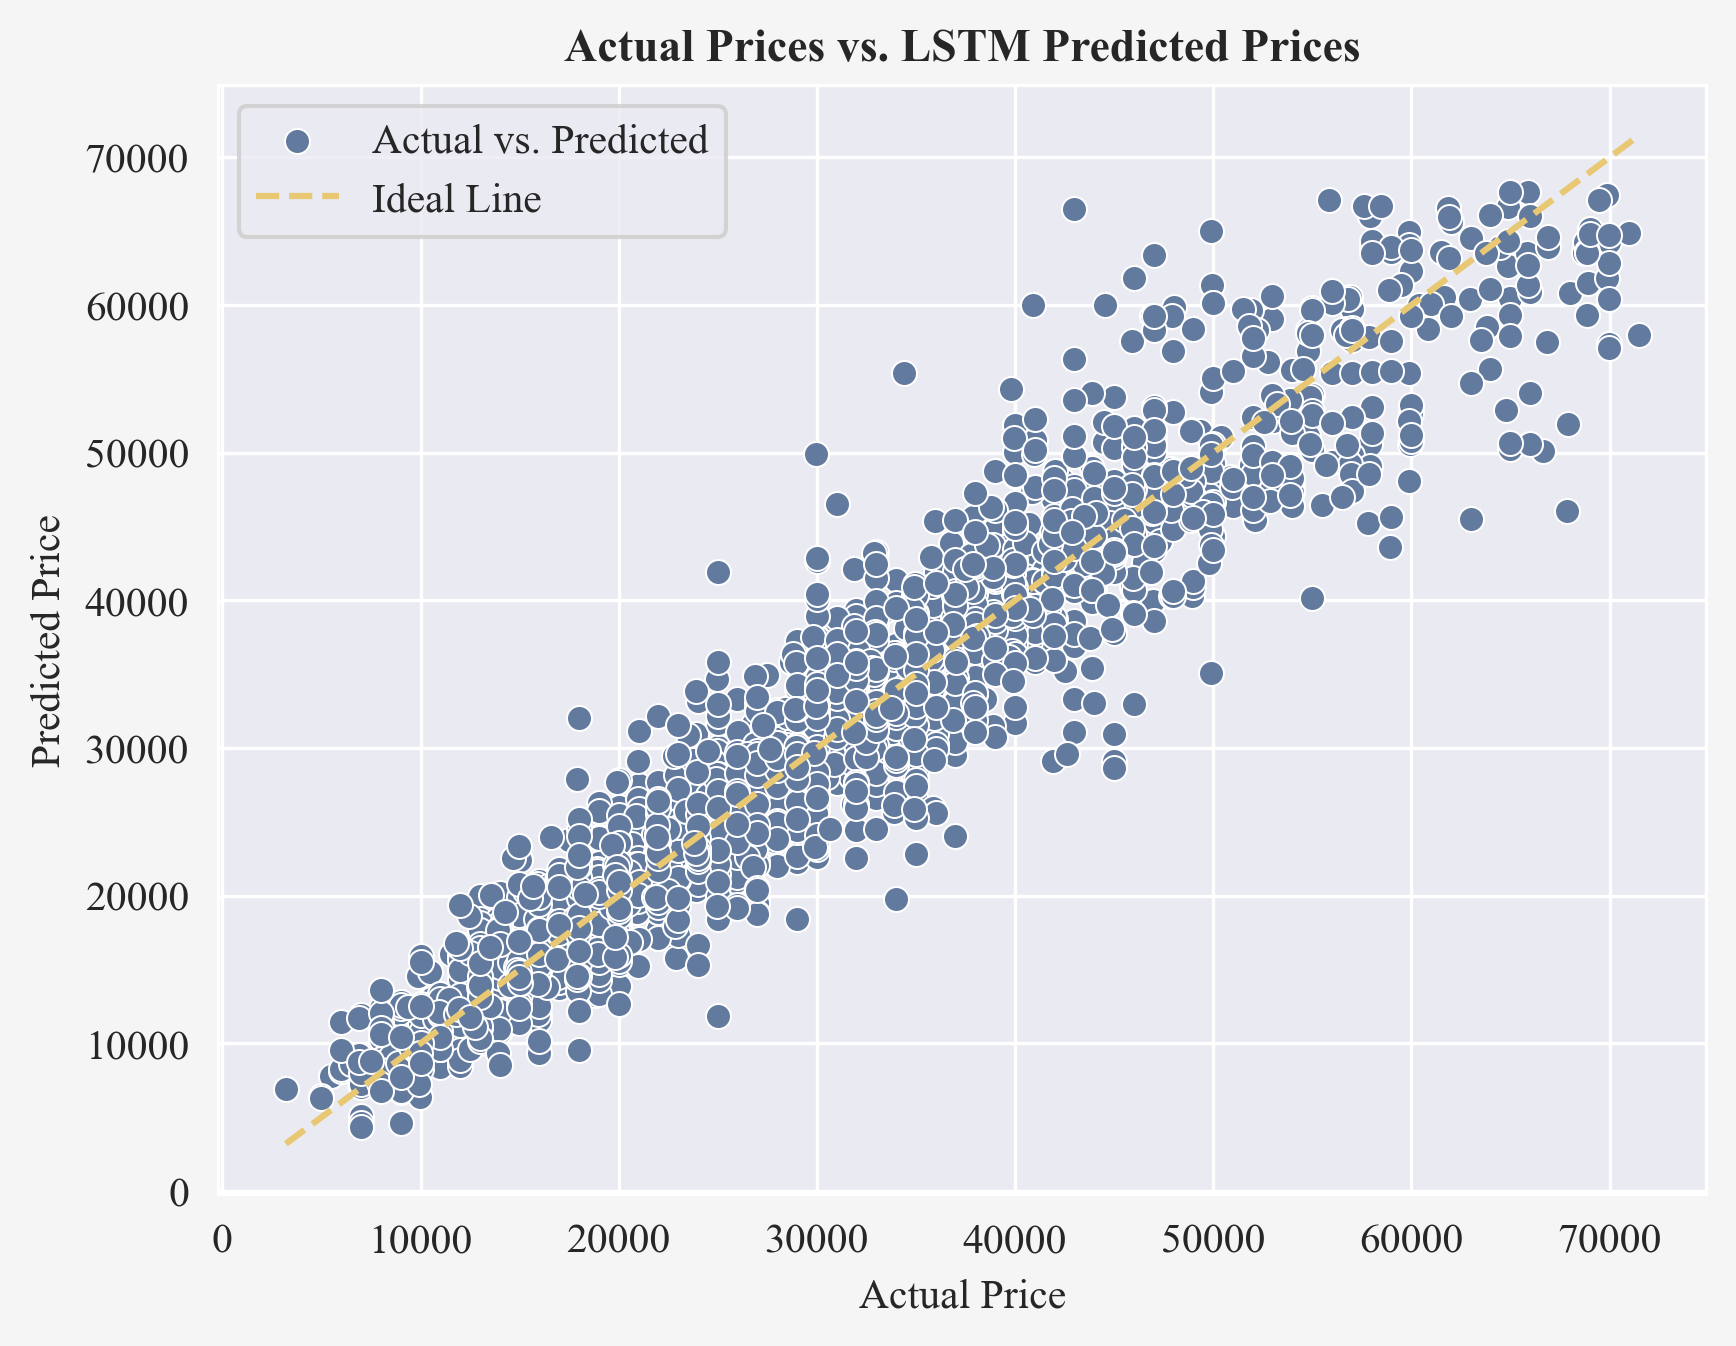

In [21]:
plt.figure(facecolor='whitesmoke', dpi=300)
sns.scatterplot(x=y_test.reshape(y_test.shape[0],),
                y=y_test_pred.reshape(y_test_pred.shape[0],), color='#637A9F', label='Actual vs. Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         '--', color='#E8C872', label='Ideal Line')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual Prices vs. LSTM Predicted Prices', fontweight='bold', fontsize=11)
plt.legend();

&nbsp;

# Final Results

| Model | R2 Train | R2 Test | MAE Train | MAE Test | RMSE Train | RMSE Test | NSE Train | NSE Test | MAPE Train | MAPE Test |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| `LR` | 0.799824 | 0.788232 | 4889.68 | 4813.31 | 6355.66 | 6315.28 | 0.799824 | 0.788232 | 0.201905 | 0.197824 |
| `Lasso` | 0.799821 | 0.788216 | 4889.73 | 4813.49 | 6355.71 | 6315.52 | 0.799821 | 0.788216 | 0.20188 | 0.197819 |
| `Ridge` | 0.799822 | 0.788207 | 4889.67 | 4813.58 | 6355.68 | 6315.66 | 0.799822 | 0.788207 | 0.201896 | 0.197817 |
| `KNN` | 0.934671 | 0.886345 | 2539.98 | 3294.64 | 3630.84 | 4626.55 | 0.934671 | 0.886345 | 0.094933 | 0.125080 |
| `DT` | 0.902504 | 0.819885 | 3173.84 | 4141.71 | 4435.55 | 5824.22 | 0.902504 | 0.819885 | 0.114780 | 0.153497 |
| `RF` | 0.964118 | 0.899318 | 1930.27 | 3139.93 | 2690.88 | 4354.50 | 0.964118 | 0.899318 | 0.07210 | 0.119418 |
| `XGBoost` | 0.957179 | 0.910412 | 2161.85 | 3017.15 | 2939.58 | 4107.58 | 0.957179 | 0.910412 | 0.080377 | 0.111979 |
| `MLP` | 0.899579 | 0.879828 | 3269.00 | 3471.06 | 4501.60 | 4757.33 | 0.899579 | 0.879828 | 0.117642 | 0.126888 |
| `LSTM` | 0.941051 | 0.906300 | 2444.13 | 3059.58 | 3448.98 | 4200.81 | 0.941051 | 0.906300 | 0.089505 | 0.114553 |